In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from astropy.table import Table

from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

import arviz as az
import pymc as pm
import random
from pymc import find_MAP
import pprint
from pymc import Model, Normal, Gamma

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
random.seed(5731)

/usr/lib/python3/dist-packages/sympy/external/importtools.py:159: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(modversion) < LooseVersion(min_module_version):
/home/grana065/.local/lib/python3.8/site-packages/pymc/aesaraf.py:49: DeprecationWarning: The module `aesara.sandbox.rng_mrg` is deprecated. Use the module `aesara.tensor.random` for random variables instead.
  from aesara.sandbox.rng_mrg import MRG_RandomStream as RandomStream


In [2]:
#read in data
data = pd.read_csv('HRStars.csv')

#filter out erroneous values
data = data[data['logL1'] > -3]
display(data.describe())

Unnamed: 0         Pday        Vmag         BmV       logM1  \
count  262.000000   262.000000  262.000000  262.000000  262.000000   
mean   158.152672    57.141912   11.014427    0.604466    0.236306   
std     91.972257   155.503202    4.023778    0.473803    0.347008   
min      0.000000     0.452000   -1.000000   -1.000000   -0.936300   
25%     77.250000     2.465750    8.295000    0.300000    0.054825   
50%    161.500000     5.206500   10.055000    0.540000    0.180550   
75%    237.750000    21.088000   14.992500    0.900000    0.369275   
max    312.000000  1550.354000   18.770000    1.800000    1.435700   

           logM1e       logM2      logM2e       logR1      logR1e  ...  \
count  262.000000  262.000000  262.000000  262.000000  262.000000  ...   
mean     0.004309    0.174120    0.004069    0.440516    0.004439  ...   
std      0.002916    0.352003    0.002729    0.497770    0.002702  ...   
min      0.000200   -0.976300    0.000100   -0.596200    0.000500  ...   
25%      0.002300   -0.007075    0.002100    0.127500    0.002500  ...   
50%      0.003550    0.137850    0.003300    0.303750    0.003900  ...   
75%      0.005975    0.348900    0.005675    0.658325    0.005675  ...   
max      0.017000    1.331000    0.014800    1.717000    0.016400  ...   

            logT1      logT1e       logT2      logT2e       logL1      logL1e  \
count  262.000000  262.000000  262.000000  262.000000  262.000000  262.000000   
mean     3.839187    0.009929    3.807566    0.011147    1.191973    0.039588   
std      0.209940    0.005692    0.207633    0.006248    1.414226    0.021883   
min      3.483000    0.002000    3.470000    0.002000   -2.258000    0.003000   
25%      3.724000    0.007000    3.685750    0.007000    0.357000    0.028000   
50%      3.796000    0.008000    3.777000    0.009500    0.979000    0.035000   
75%      3.894500    0.012000    3.853750    0.013000    2.088250    0.048000   
max      4.580000    0.042000    4.531000    0.050000    5.187000    0.170000   

            logL2      logL2e         MoH        MoHe  
count  262.000000  262.000000  262.000000  262.000000  
mean     0.921271    0.044500   -4.860458   -4.712557  
std      1.497681    0.022023    4.880974    5.043607  
min     -2.313000    0.003000   -9.990000   -9.990000  
25%      0.051750    0.030000   -9.990000   -9.990000  
50%      0.710000    0.040000   -1.135000    0.000000  
75%      1.939250    0.055750   -0.110000    0.100000  
max      4.920000    0.130000    0.550000    0.350000  

[8 rows x 26 columns]

<AxesSubplot:xlabel='logT1', ylabel='logL1'>

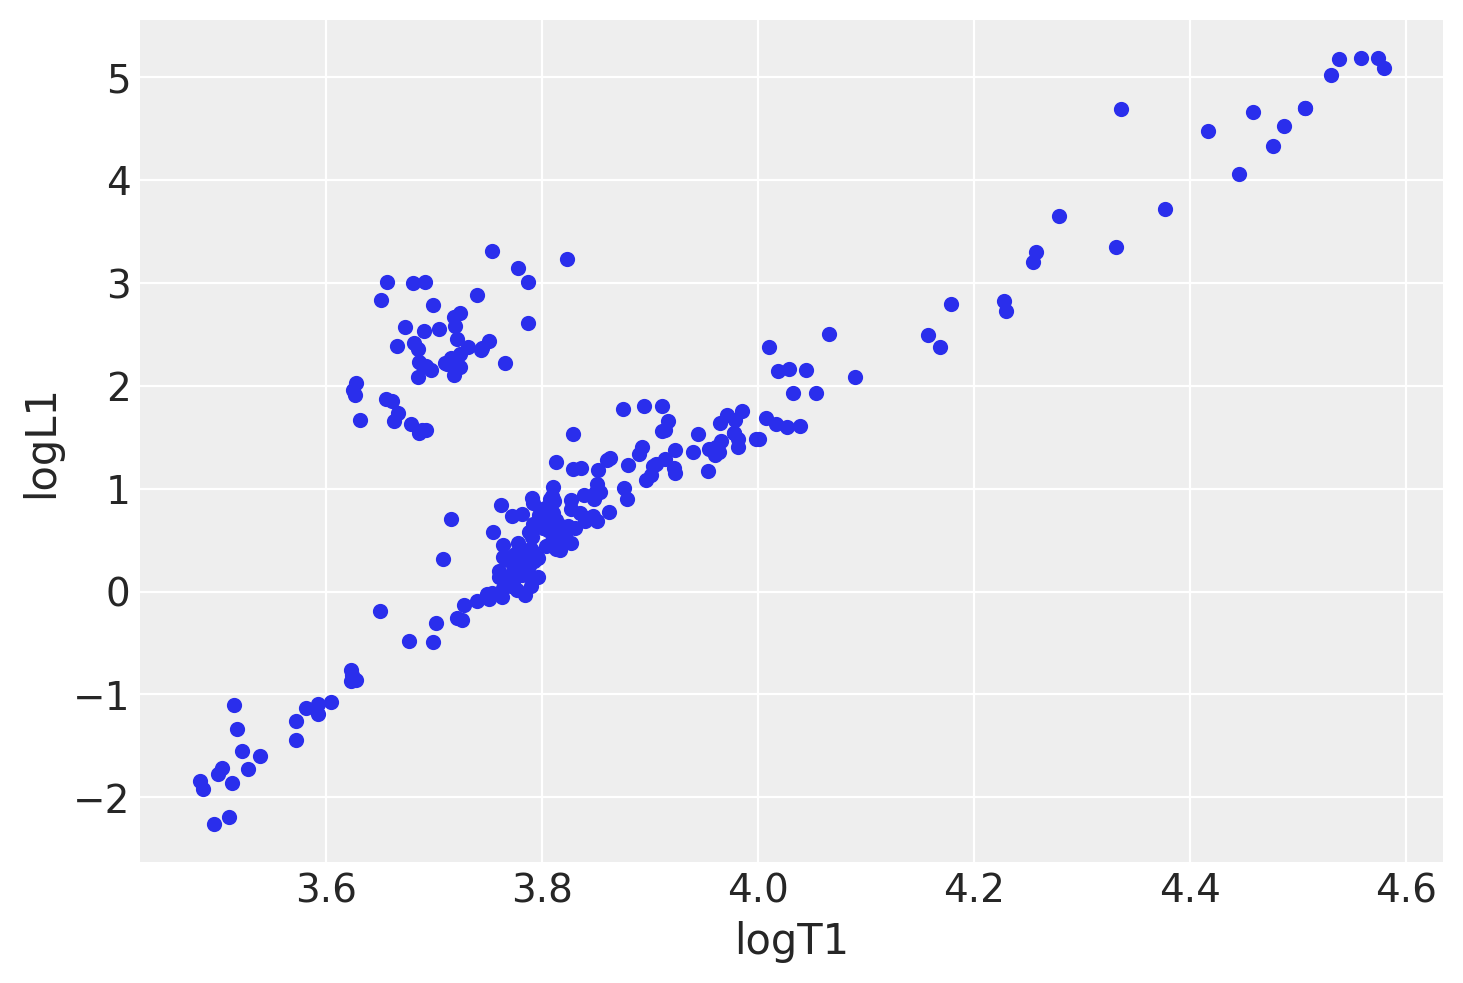

In [3]:
data.plot(x='logT1', y='logL1', kind='scatter')

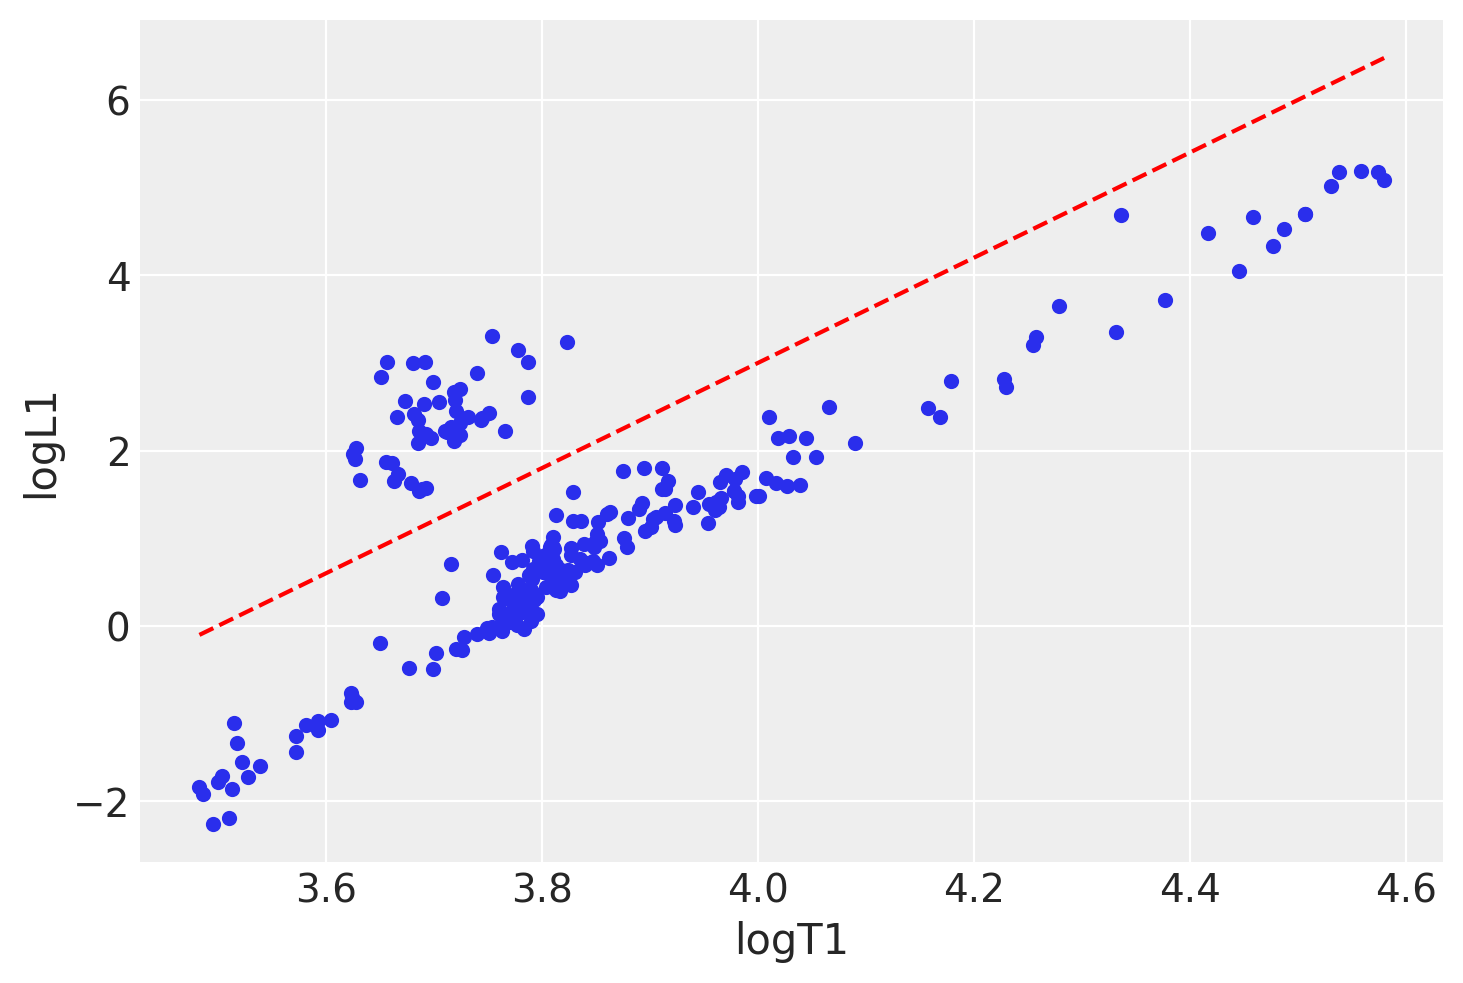

In [4]:
#identifying red giants

ax1 = data.plot(x='logT1', y='logL1', kind='scatter')

ax1.plot(data['logT1'], data['logT1']*6-21, 'r--')

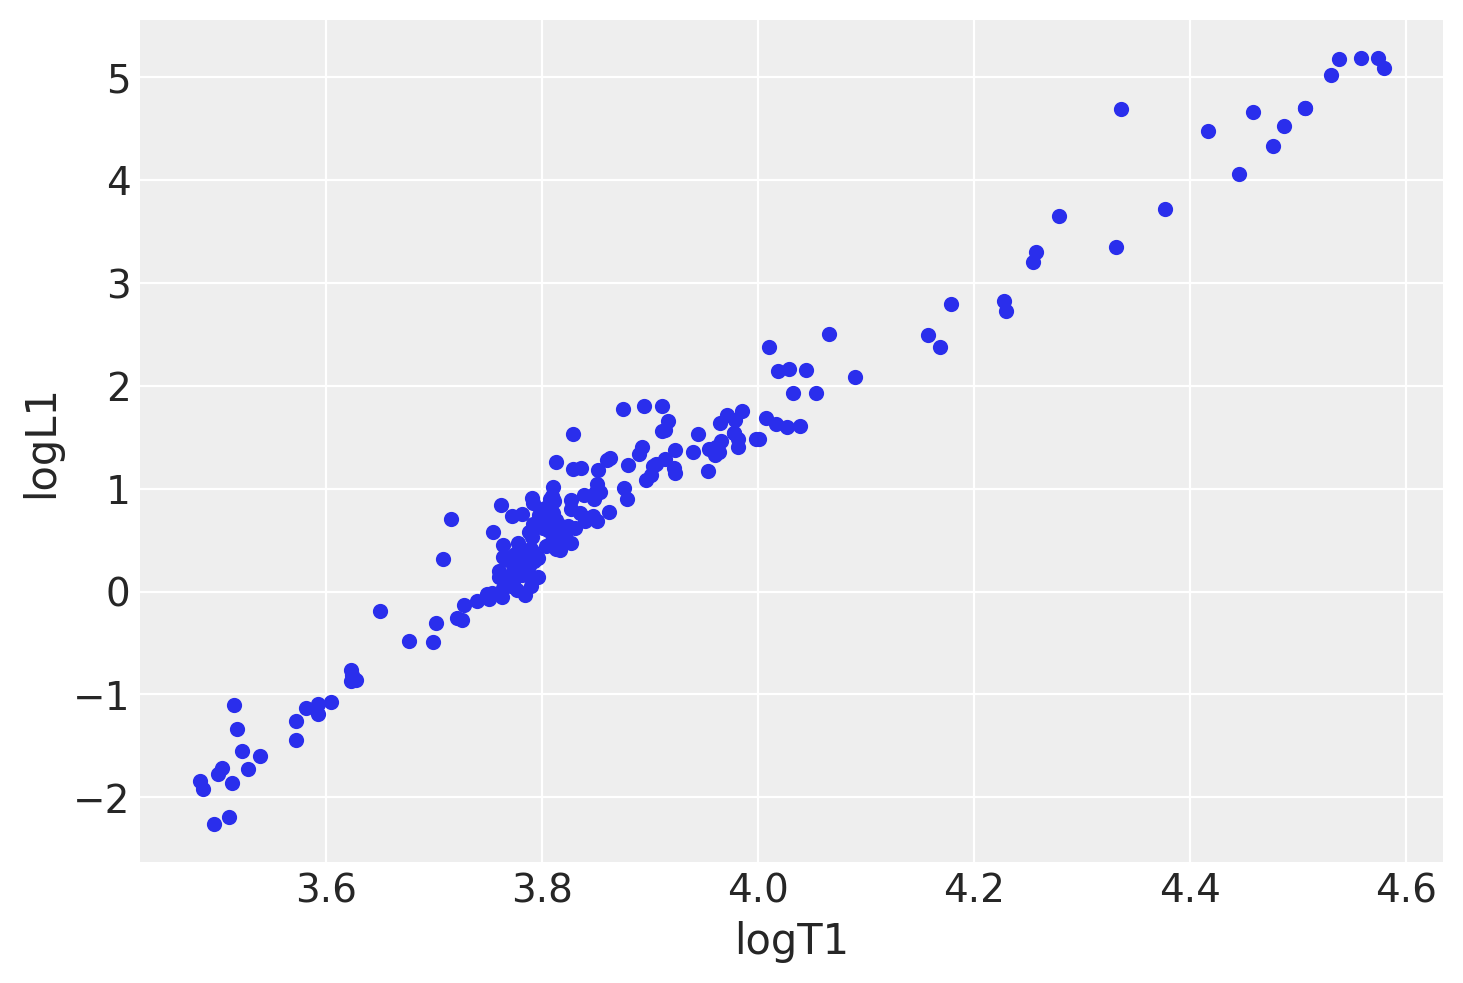

In [5]:
#removing red giants
data_cut = data[data['logL1'] < (6*data['logT1']-21)]
data_cut.plot(x='logT1', y='logL1', kind='scatter')

cm = plt.cm.get_cmap('RdYlBu')

<AxesSubplot:ylabel='Frequency'>

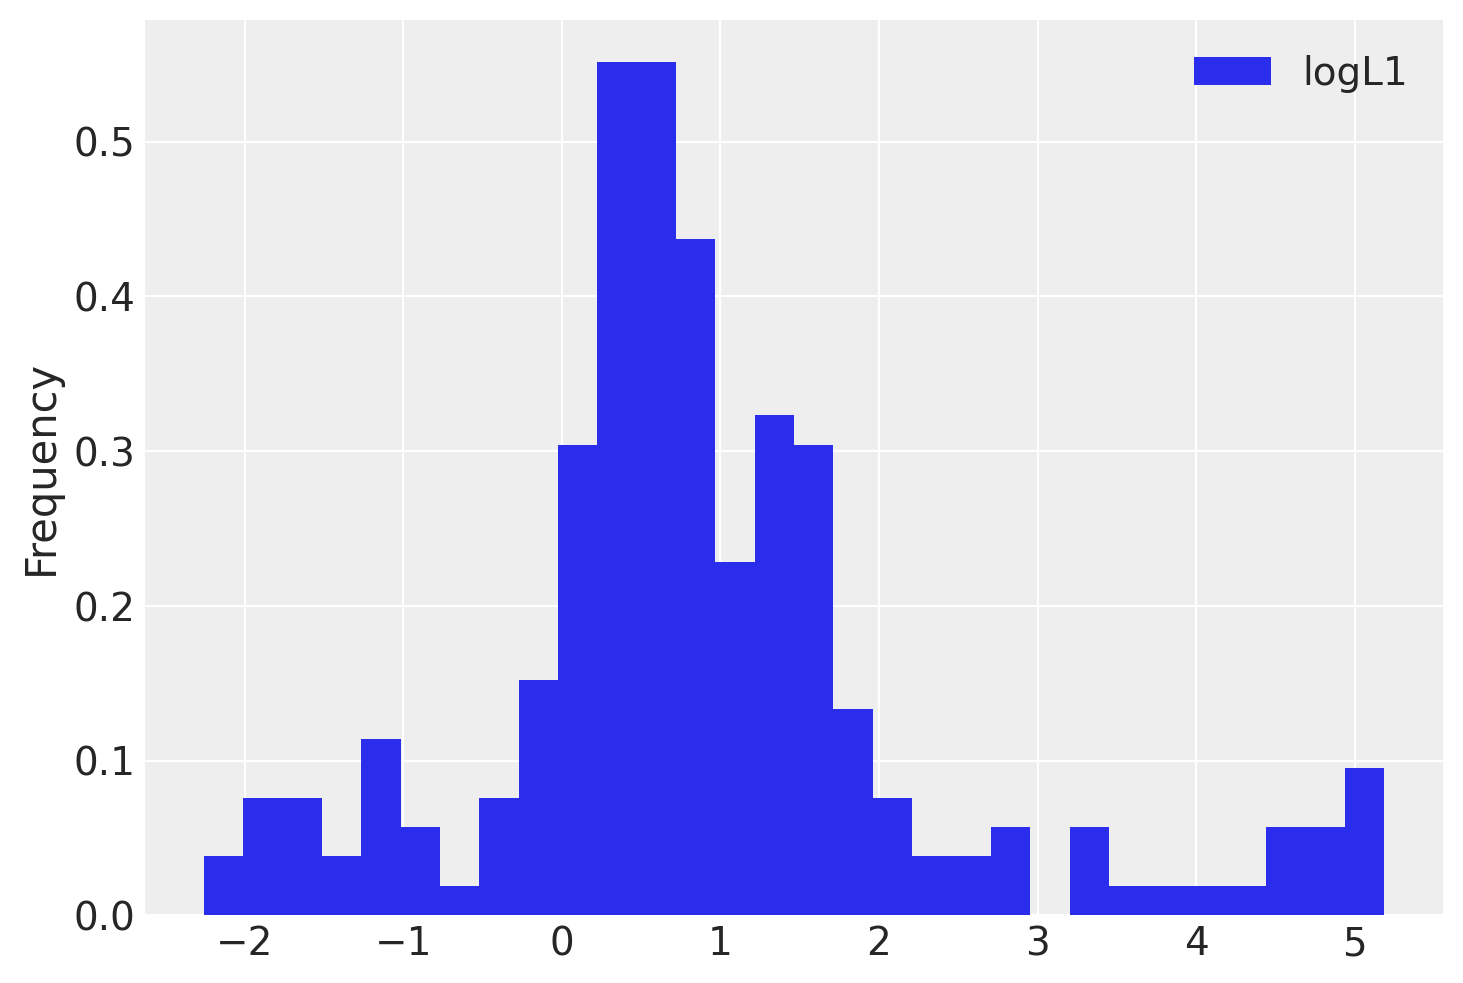

In [6]:
data_cut.plot(x='logT1', y='logL1', kind='hist', density=True, bins=30)

In [7]:
x = data_cut['logT1']
x_err = data_cut['logT1e']

y = data_cut['logL1']
y_err = data_cut['logL1e']

#### Linear fit to model

Shape of X (212, 2)
Shape of Y (212,)
Beta:  [[-23.61122803   6.3368916 ]]


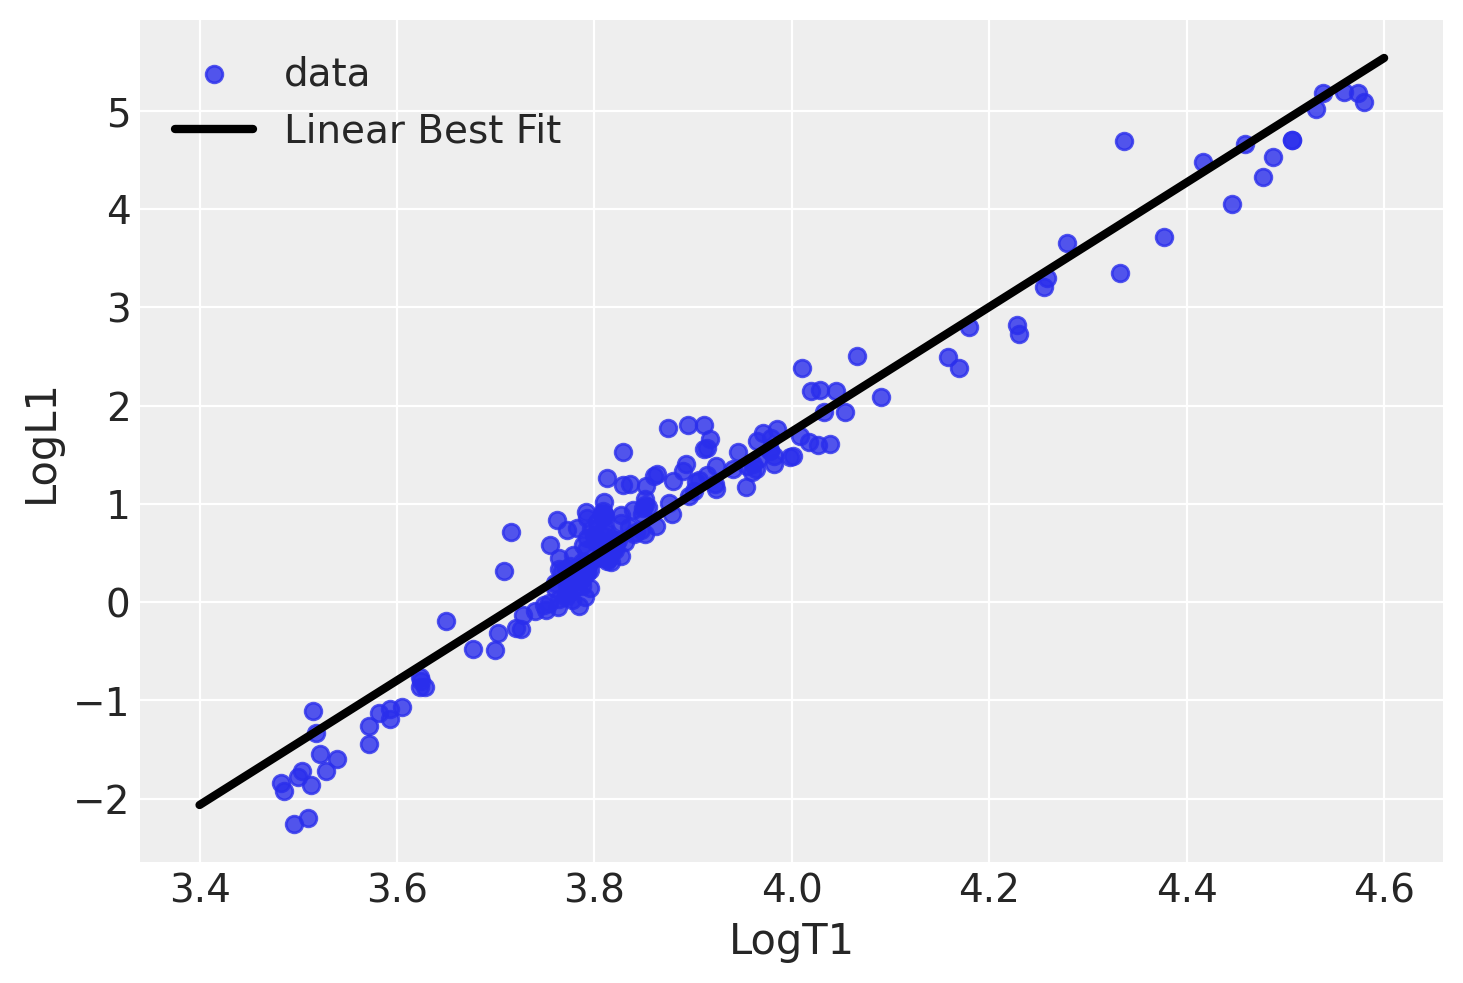

In [8]:
#setting up matrices

X = np.matrix([np.ones(x.shape[0]), x]).T
print('Shape of X',X.shape)
print('Shape of Y',y.shape)

#compute MLE estimator
p_mat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print('Beta: ', p_mat)

#define new X variable for plotting
xx = np.linspace(3.4, 4.6, 100)
#compute the line
yy = np.array(p_mat[0,0]+p_mat[0,1]*xx)

#plotting

plt.scatter(x, y, alpha = 0.8, label='data')
plt.plot(xx, yy, 'k-', linewidth=3, label='Linear Best Fit')
plt.xlabel(r'LogT1')
plt.ylabel(r'LogL1')
plt.legend()
plt.show()

### Bayesian Regression, no errors

In [9]:
basic_model = Model()

with basic_model:
    #priors for unknown model parameters
    beta = Normal('beta', mu=0, tau=1e-3, shape=2)
    precision = Gamma('precision', alpha=0.5, beta=0.5)
    
    #expected value of outcome
    mu = beta[0] + beta[1]*x
    
    #likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [10]:
map_estimate = find_MAP(model=basic_model)
map_estimate

{'beta': array([-23.60795949,   6.33604984]),
 'precision_log__': array(2.4255216),
 'precision': array(11.30812616)}

In [11]:
with basic_model:
    start = find_MAP()
    
    #draw 1000 posterior samples
    trace = pm.sample(start=start, return_inferencedata=True)

<ipython-input-11-303b0271aa08>:5: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(start=start, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
/usr/lib/python3/dist-packages/numba/targets/arraymath.py:3670: DeprecationWarning: `np.MachAr` is deprecated (NumPy 1.22).
  @overload(np.MachAr)
/usr/lib/python3/dist-packages/numba/ir_utils.py:1512: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/lib/python3/dist-packages/numba/ir_utils.py:1513: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.f

In [12]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -23.611  0.366 -24.293  -22.932      0.011    0.008    1132.0   
beta[1]     6.337  0.094   6.159    6.512      0.003    0.002    1132.0   
precision  11.286  1.071   9.438   13.396      0.026    0.019    1644.0   

           ess_tail  r_hat  
beta[0]      1322.0    1.0  
beta[1]      1358.0    1.0  
precision    1492.0    1.0

In [13]:
#get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -23.6 6.337 ... -22.89 6.144
    precision   (chain, draw) float64 10.91 10.4 11.57 ... 11.35 10.02 10.03
Attributes:
    created_at:                 2022-11-23T00:37:01.704727
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              8.90493631362915
    tuning_steps:               1000

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'precision'}>,
        <AxesSubplot:title={'center':'precision'}>]], dtype=object)

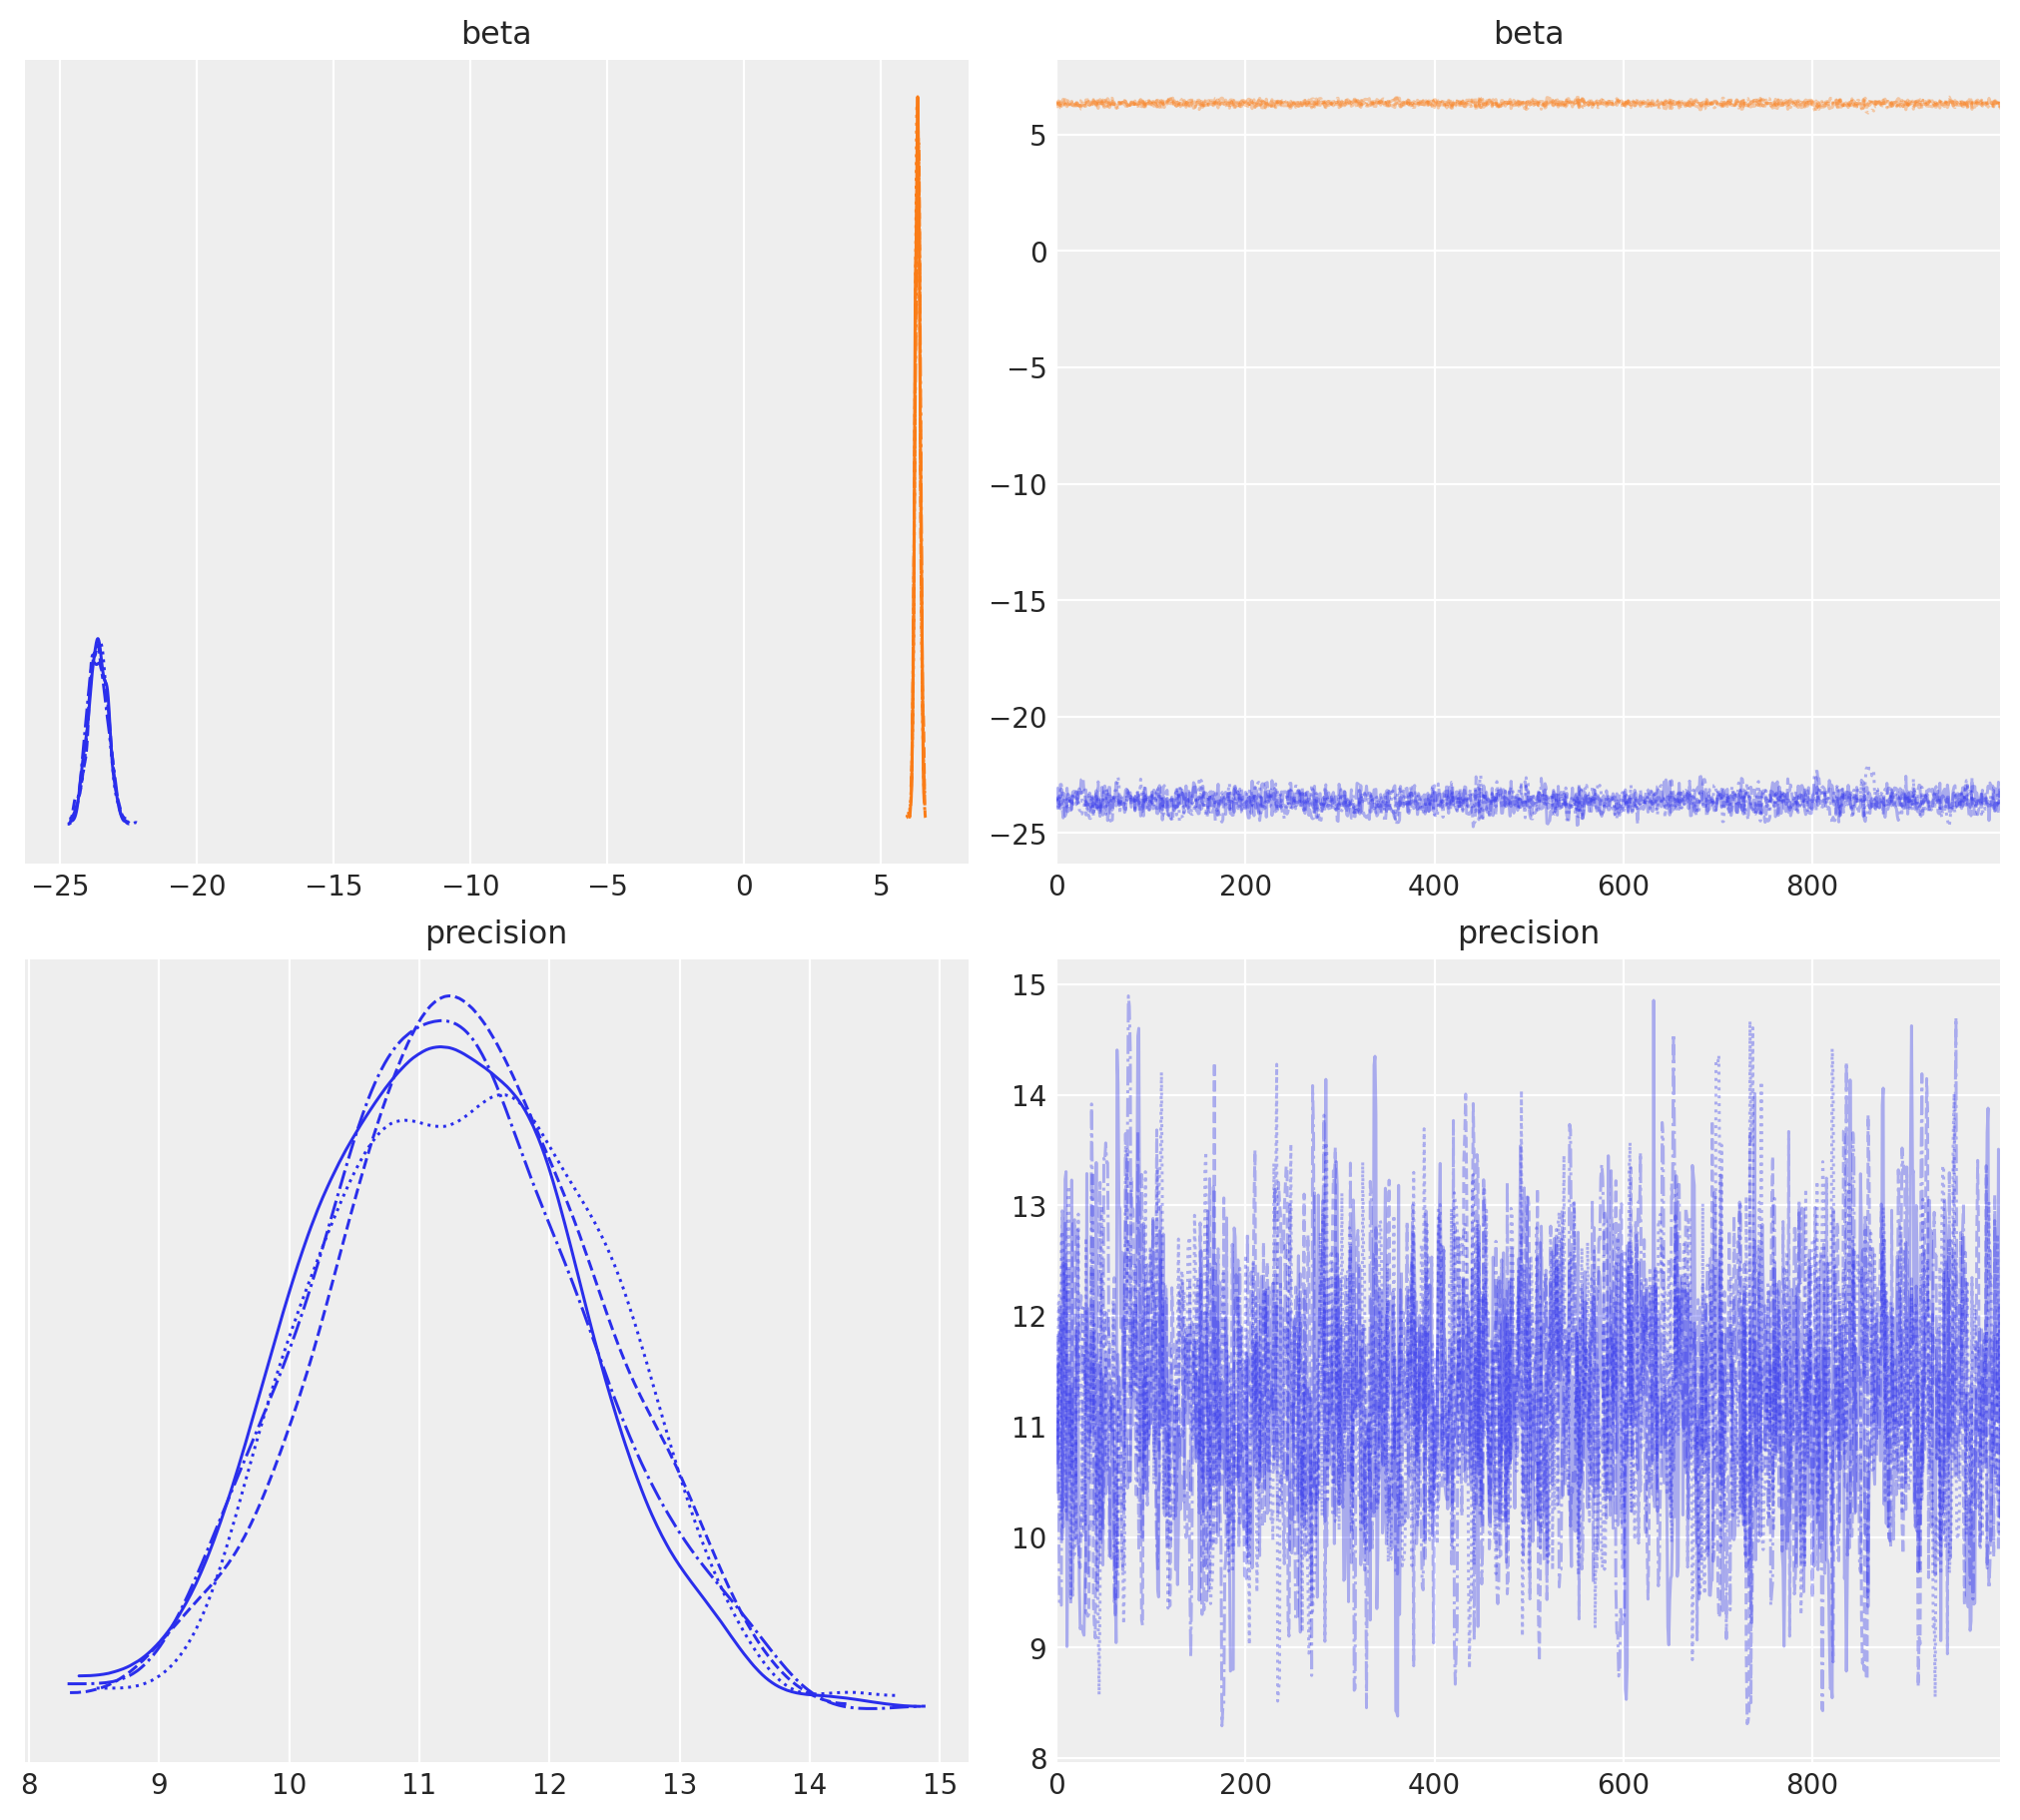

In [14]:
az.plot_trace(trace, figsize=(10,9))

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'precision'}>], dtype=object)

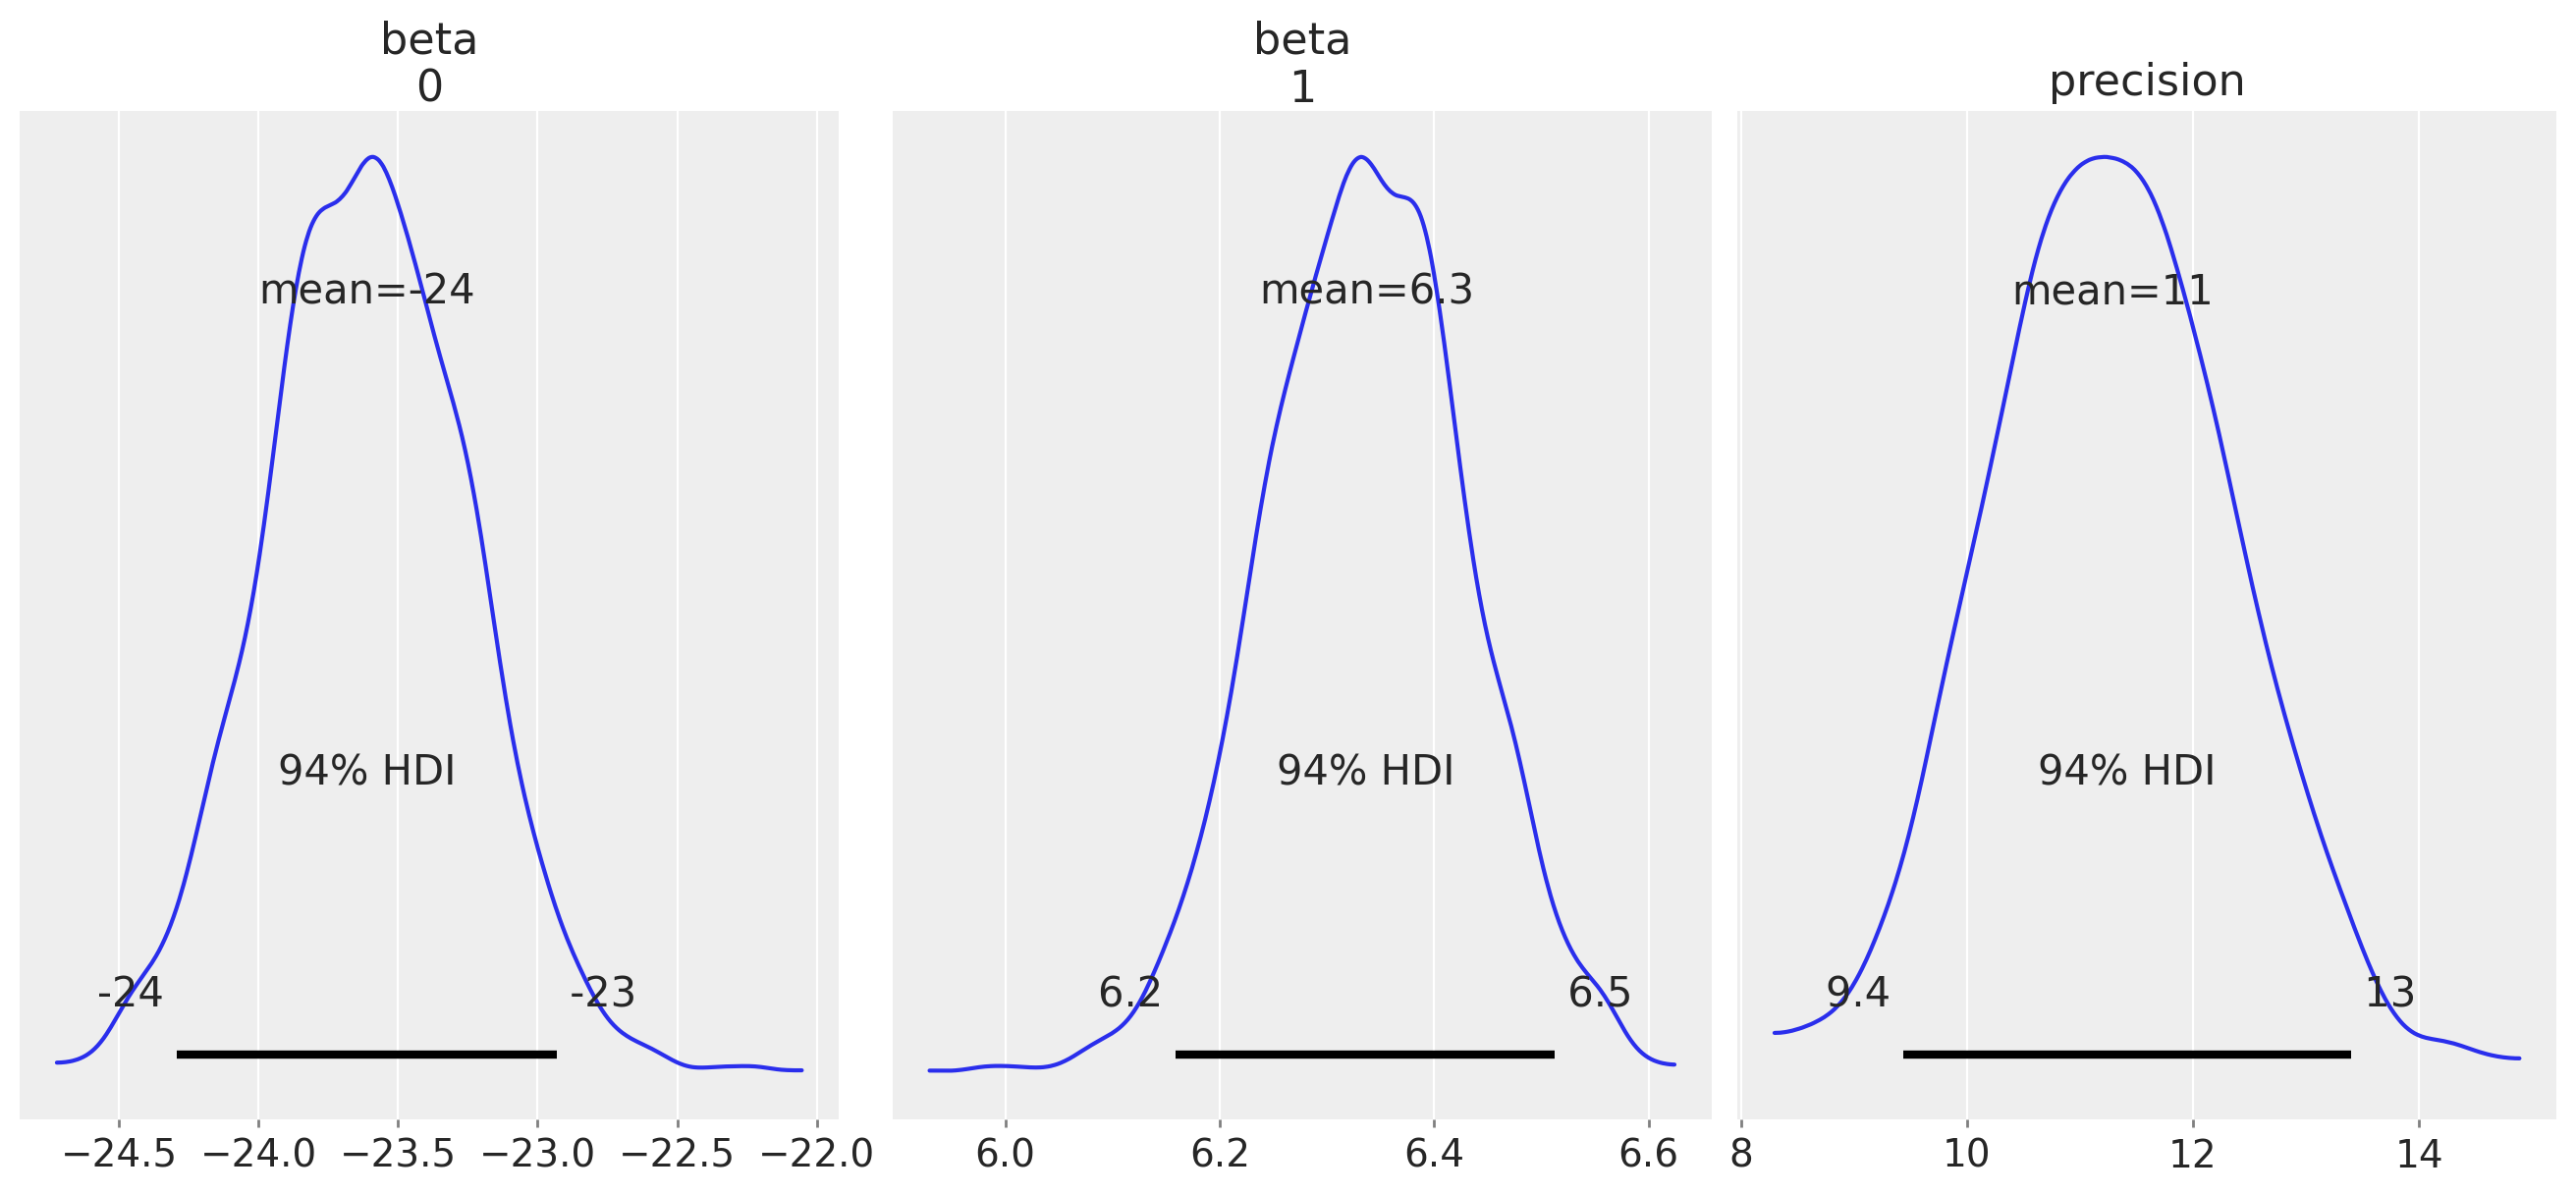

In [15]:
az.plot_posterior(trace,figsize=(13,6))

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>], dtype=object)

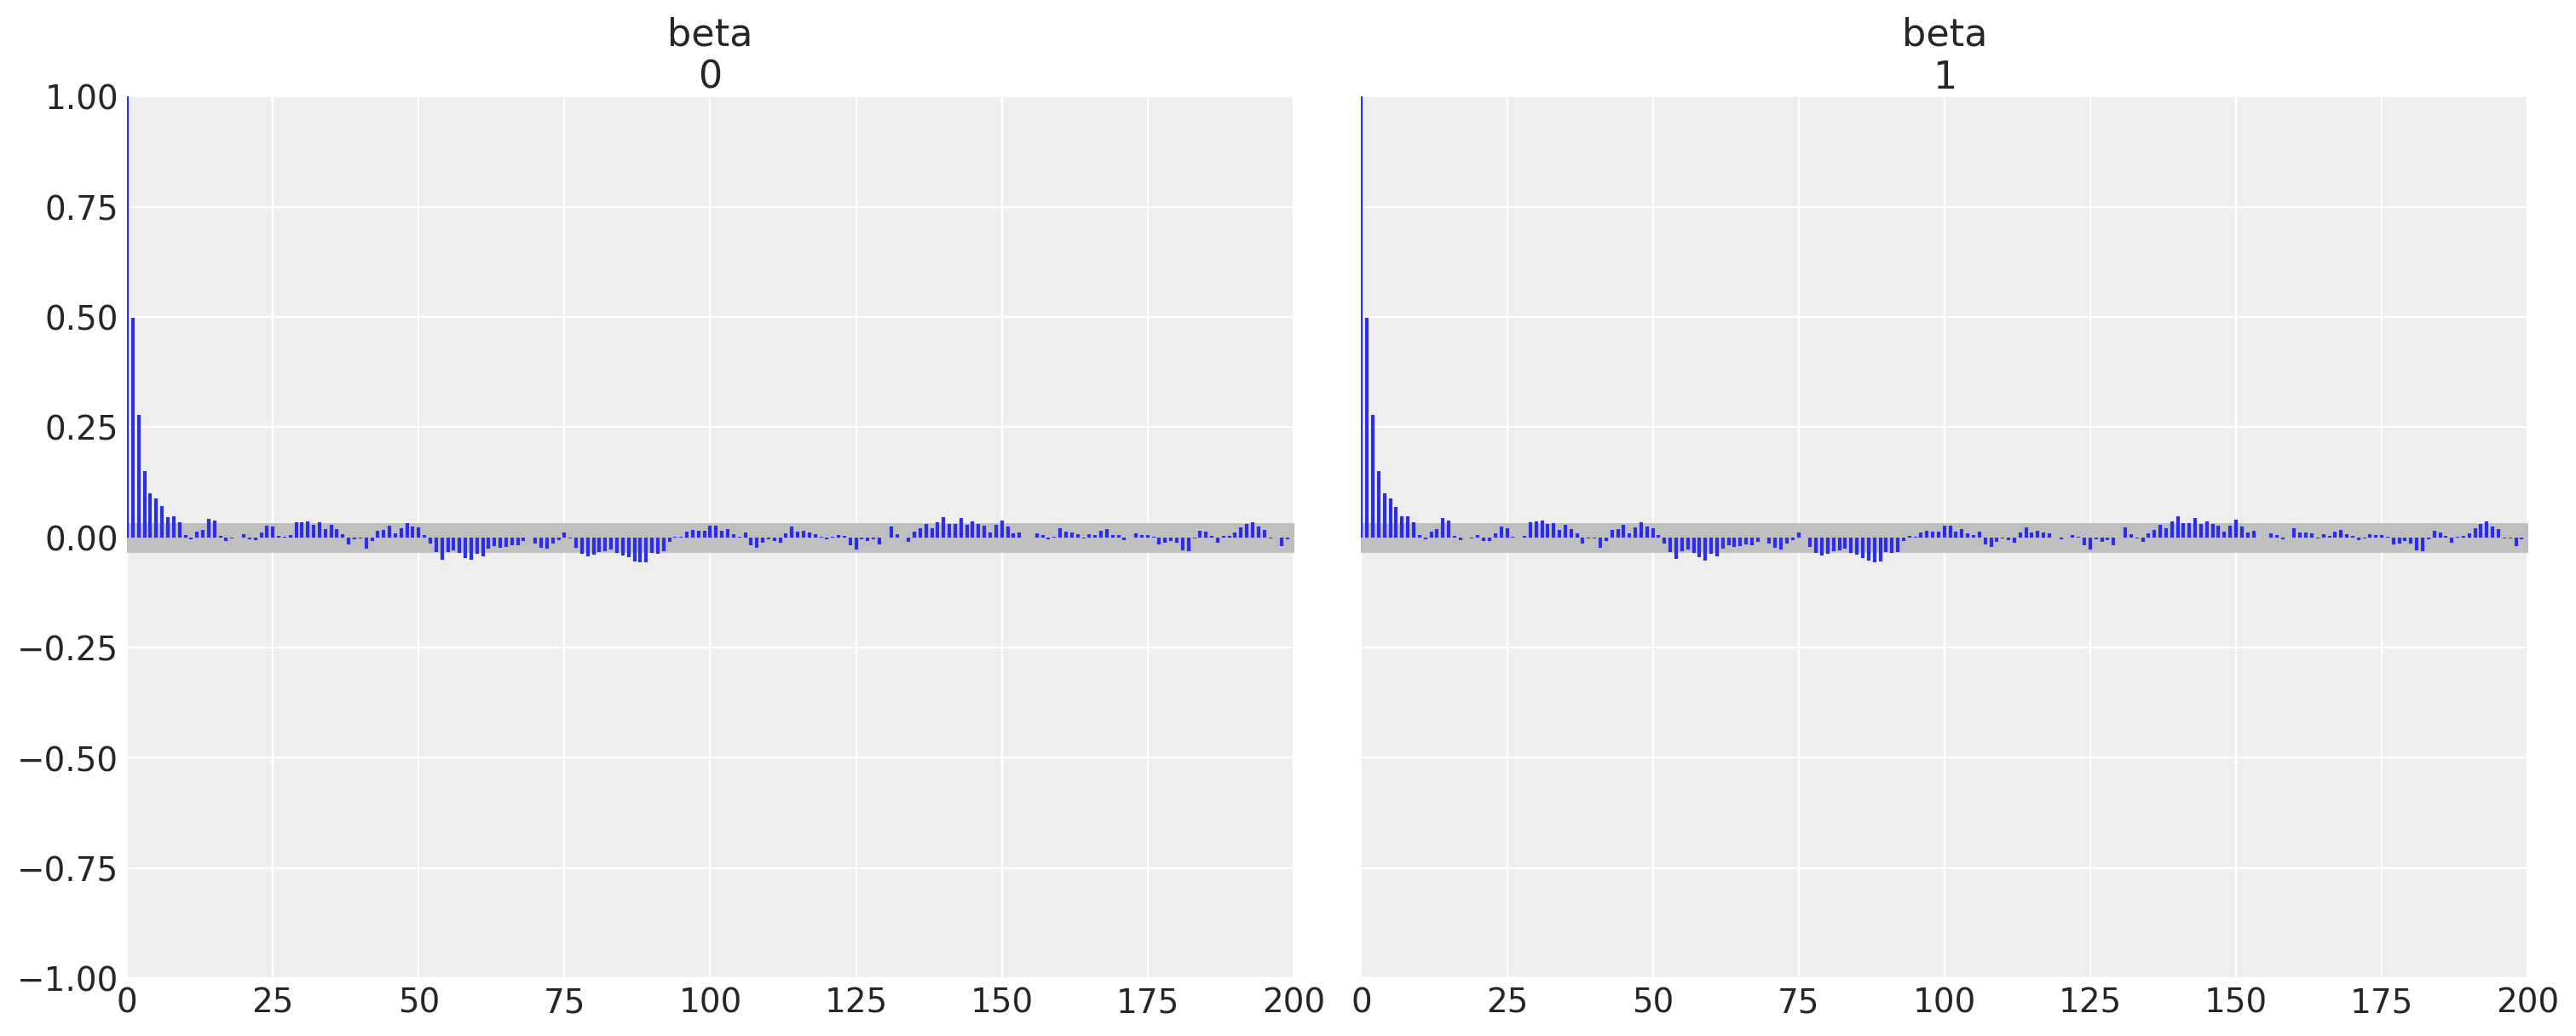

In [16]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars='like', max_lag=200, combined=True, figsize=(15,6))

In [17]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [Y_obs]


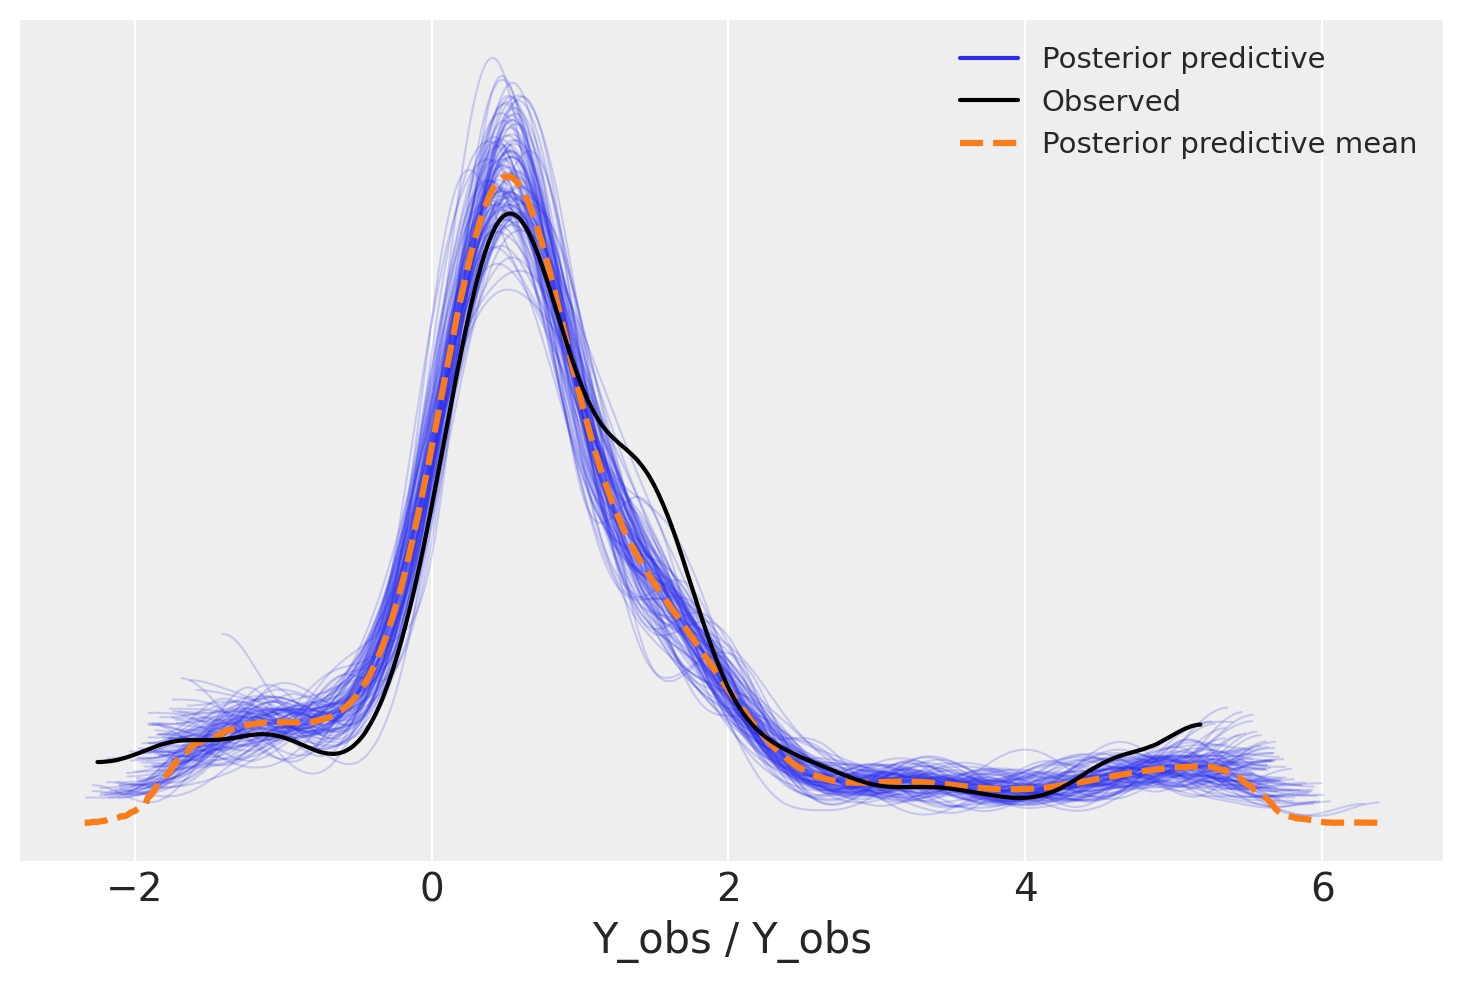

In [18]:
az.plot_ppc(trace, num_pp_samples=100);

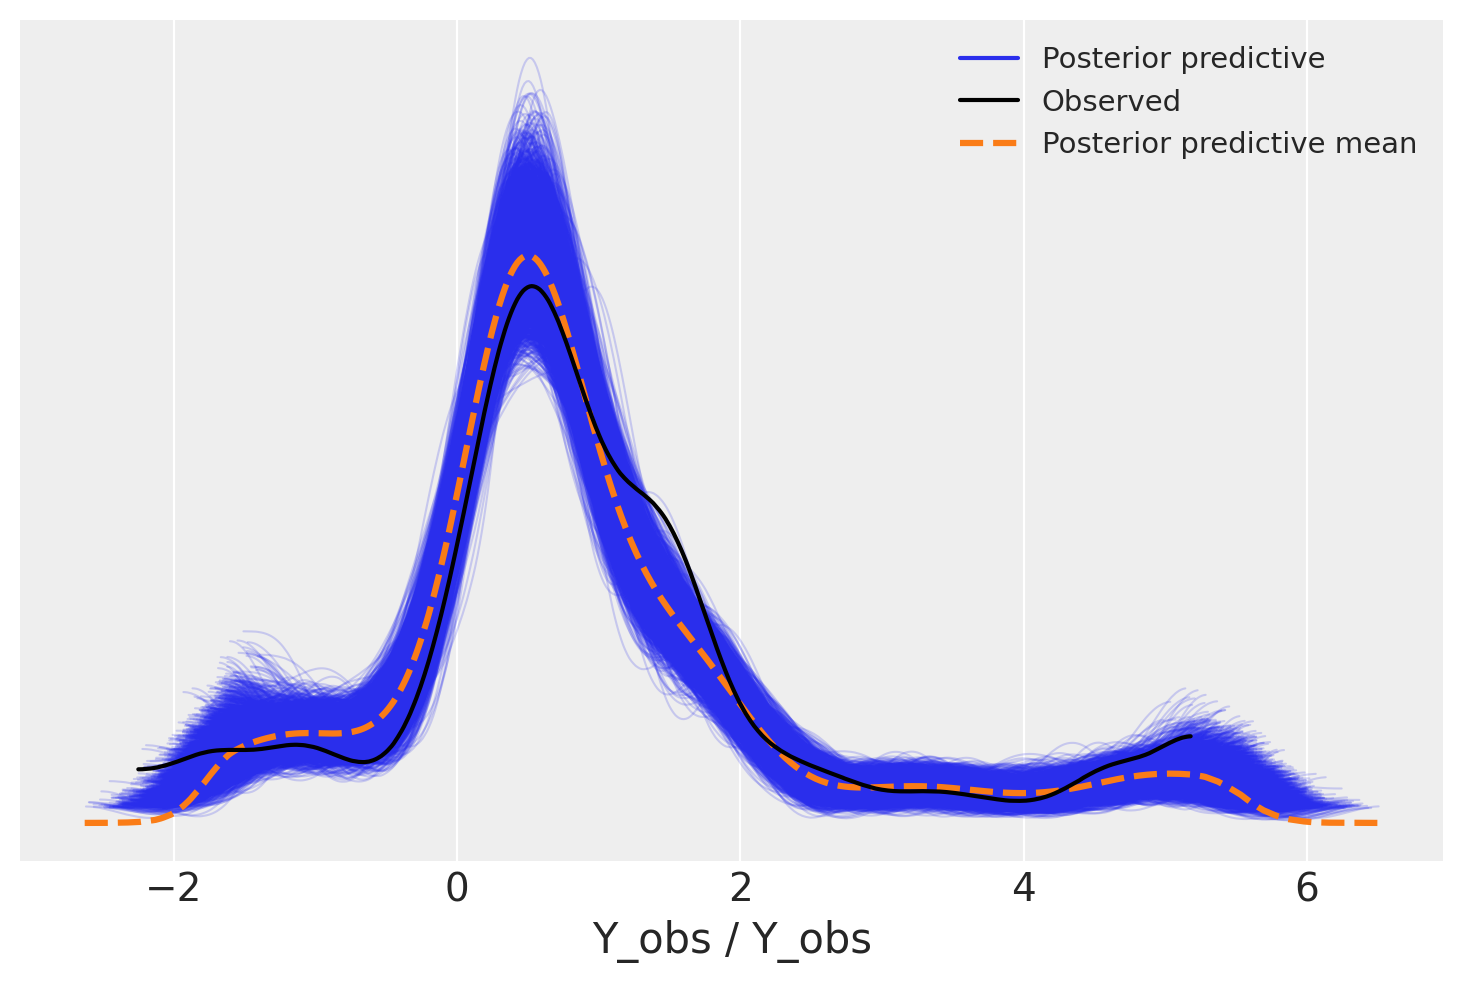

In [19]:
az.plot_ppc(trace);

In [20]:
az.summary(trace.posterior_predictive)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Y_obs[0]   -1.543  0.306  -2.126   -0.992      0.005    0.003    3956.0   
Y_obs[1]   -1.462  0.305  -2.054   -0.912      0.005    0.003    4172.0   
Y_obs[2]   -1.376  0.303  -1.957   -0.809      0.005    0.003    4076.0   
Y_obs[3]   -1.332  0.308  -1.896   -0.742      0.005    0.004    3815.0   
Y_obs[4]   -1.529  0.305  -2.136   -0.972      0.005    0.003    3896.0   
...           ...    ...     ...      ...        ...      ...       ...   
Y_obs[207]  5.375  0.303   4.833    5.961      0.005    0.003    4104.0   
Y_obs[208]  5.104  0.307   4.534    5.671      0.005    0.004    3711.0   
Y_obs[209]  5.153  0.299   4.567    5.684      0.005    0.003    3711.0   
Y_obs[210]  5.280  0.306   4.718    5.848      0.005    0.004    3574.0   
Y_obs[211]  5.413  0.309   4.851    6.009      0.005    0.004    3728.0   

            ess_tail  r_hat  
Y_obs[0]      3816.0    1.0  
Y_obs[1]      3933.0    1.0  
Y_obs[2]      3736.0    1.0  
Y_obs[3]      3728.0    1.0  
Y_obs[4]      3742.0    1.0  
...              ...    ...  
Y_obs[207]    3585.0    1.0  
Y_obs[208]    3804.0    1.0  
Y_obs[209]    4056.0    1.0  
Y_obs[210]    3735.0    1.0  
Y_obs[211]    4008.0    1.0  

[212 rows x 9 columns]

### Sensitivity Analysis

above I used priors $\beta ~ N(a,b), \lambda ~ Gamma(c,d)$ where $a=0, b=1\mathrm{x}10^{-3}, c=d=0.5$

now testing for new priors.

<ipython-input-35-3badbd26736d>:25: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set1 = pm.sample(start=start_set1, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [Y_obs]


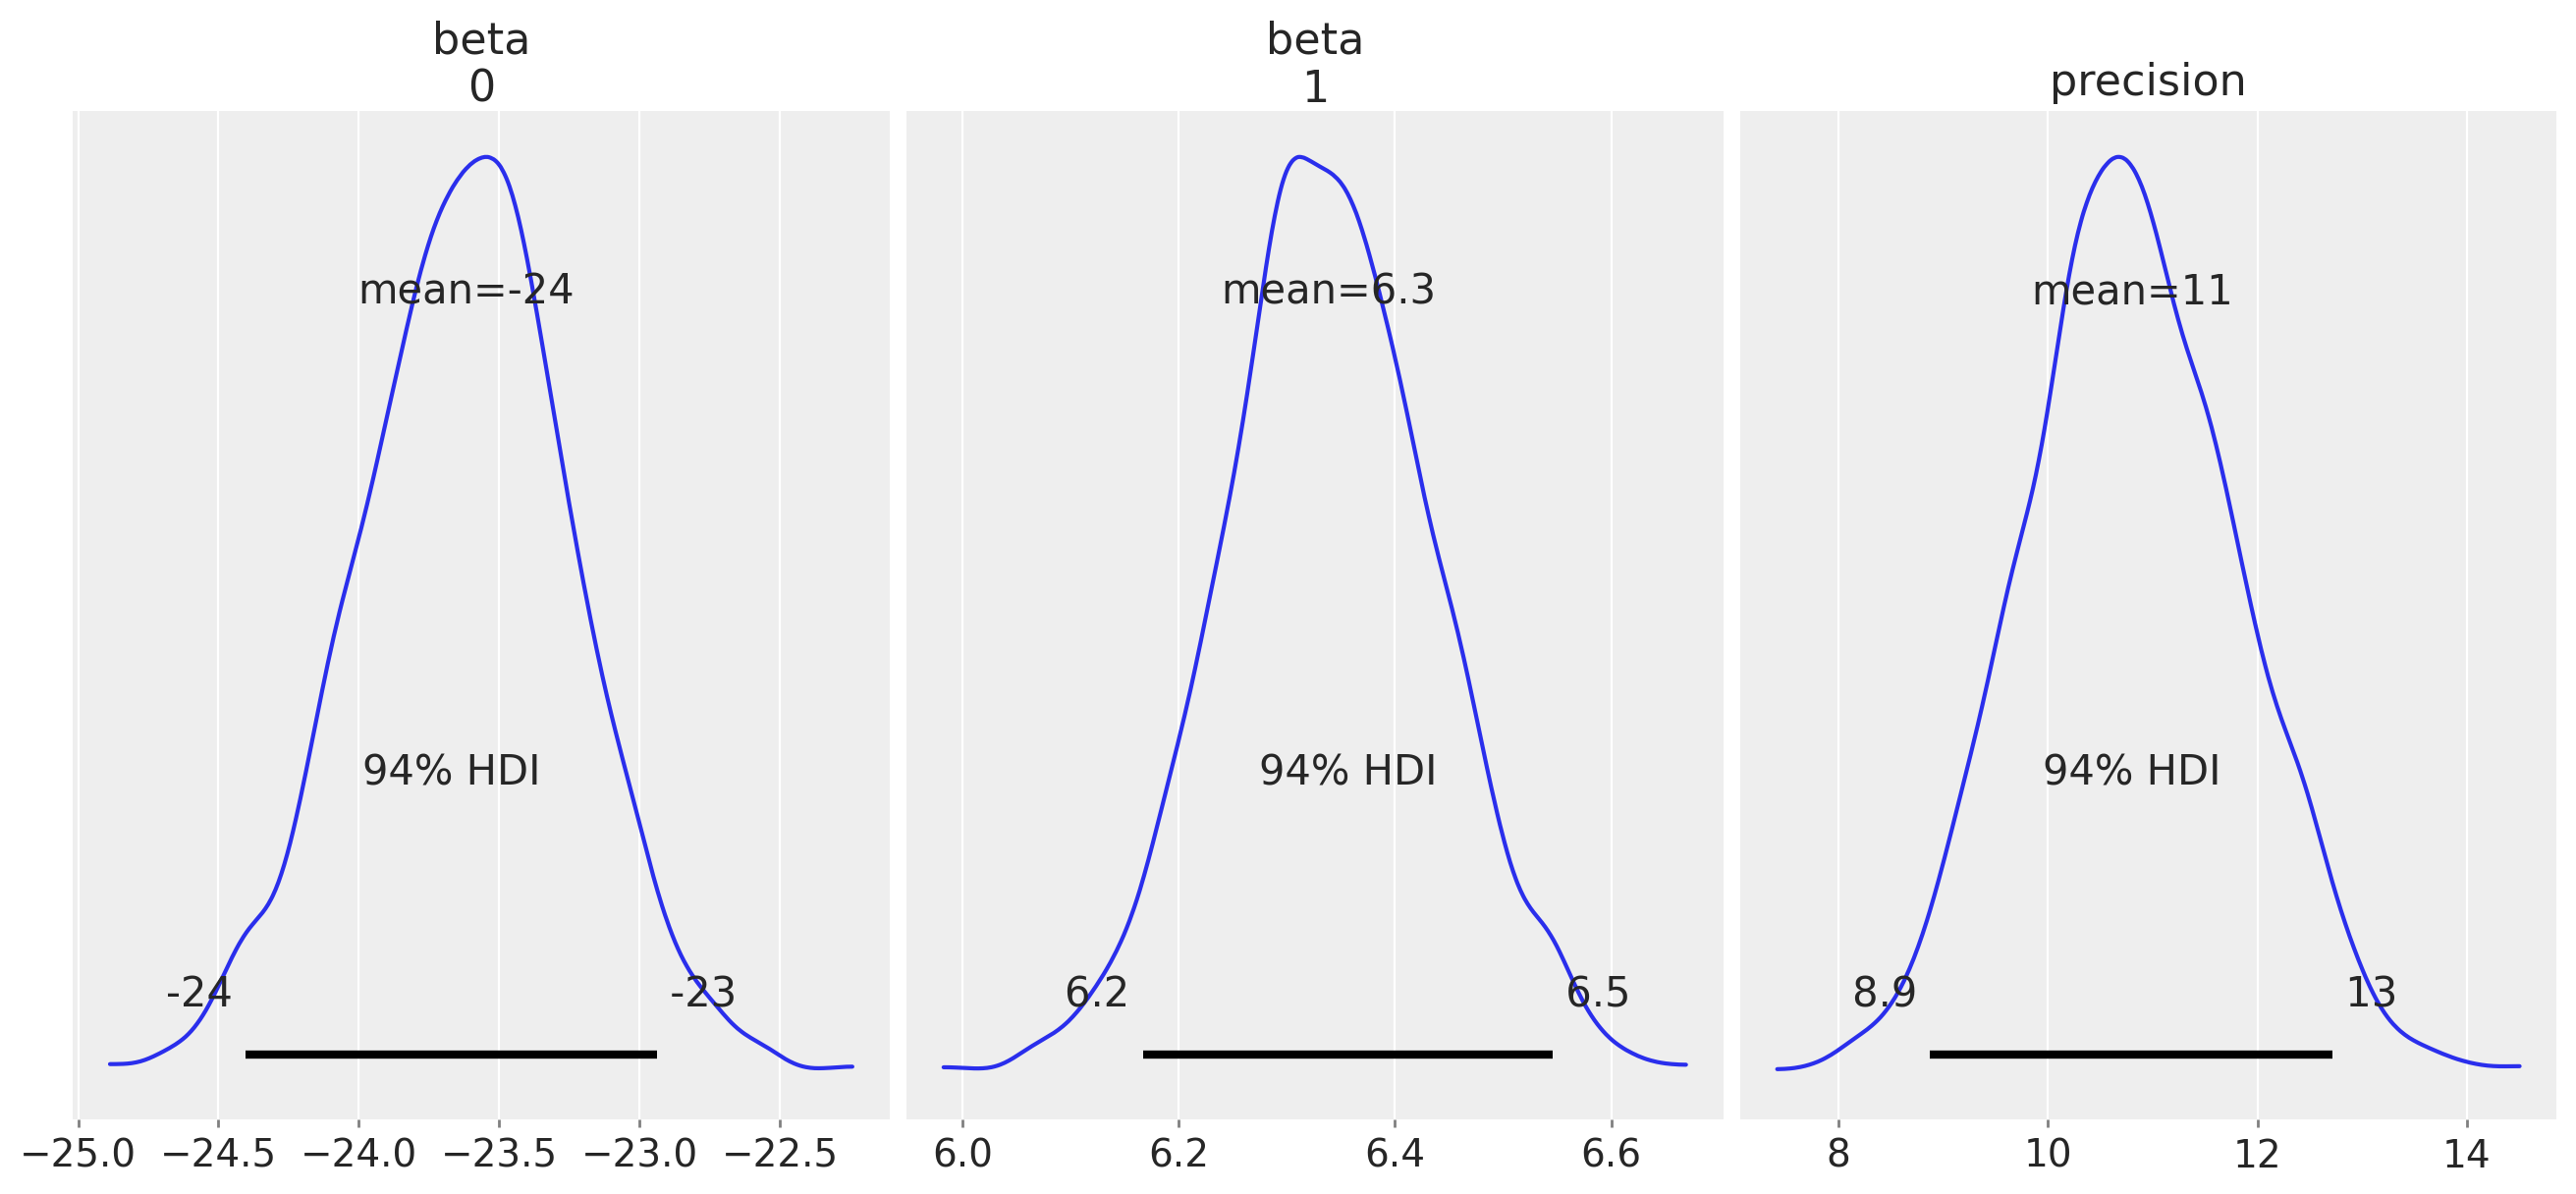

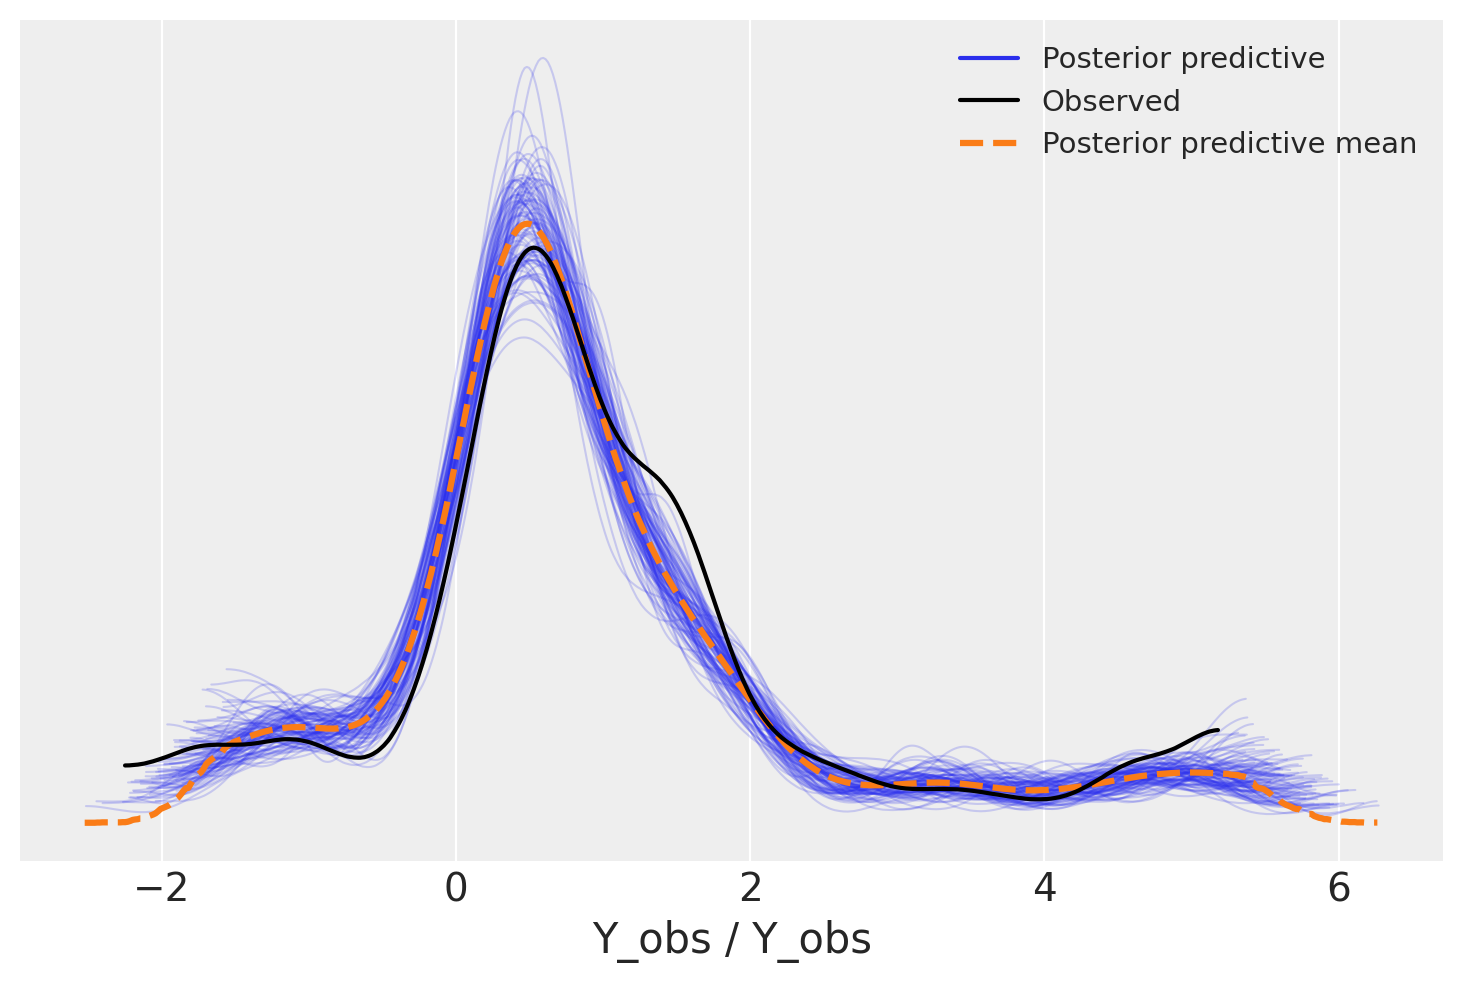

In [35]:
a=0
b=1e-3
c=1
d=1

basic_model_set1 = Model()

with basic_model_set1:
    #priors for unknown model parameters
    beta = Normal('beta', mu=a, tau=b, shape=2)
    precision = Gamma('precision', alpha=c, beta=d)
    
    #expected value of outcome
    mu = beta[0] + beta[1]*x
    
    #likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

map_estimate_set1 = find_MAP(model=basic_model)

with basic_model_set1:
    start_set1 = find_MAP()
    
    #draw 1000 posterior samples
    trace_set1 = pm.sample(start=start_set1, return_inferencedata=True)

az.plot_posterior(trace_set1,figsize=(13,6))
posterior_set1 = trace_set1.posterior

with basic_model_set1:
    pm.sample_posterior_predictive(trace_set1, extend_inferencedata=True)

az.plot_ppc(trace_set1, num_pp_samples=100);

<ipython-input-45-7833ab3a6228>:25: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(start=start_set2, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [Y_obs]


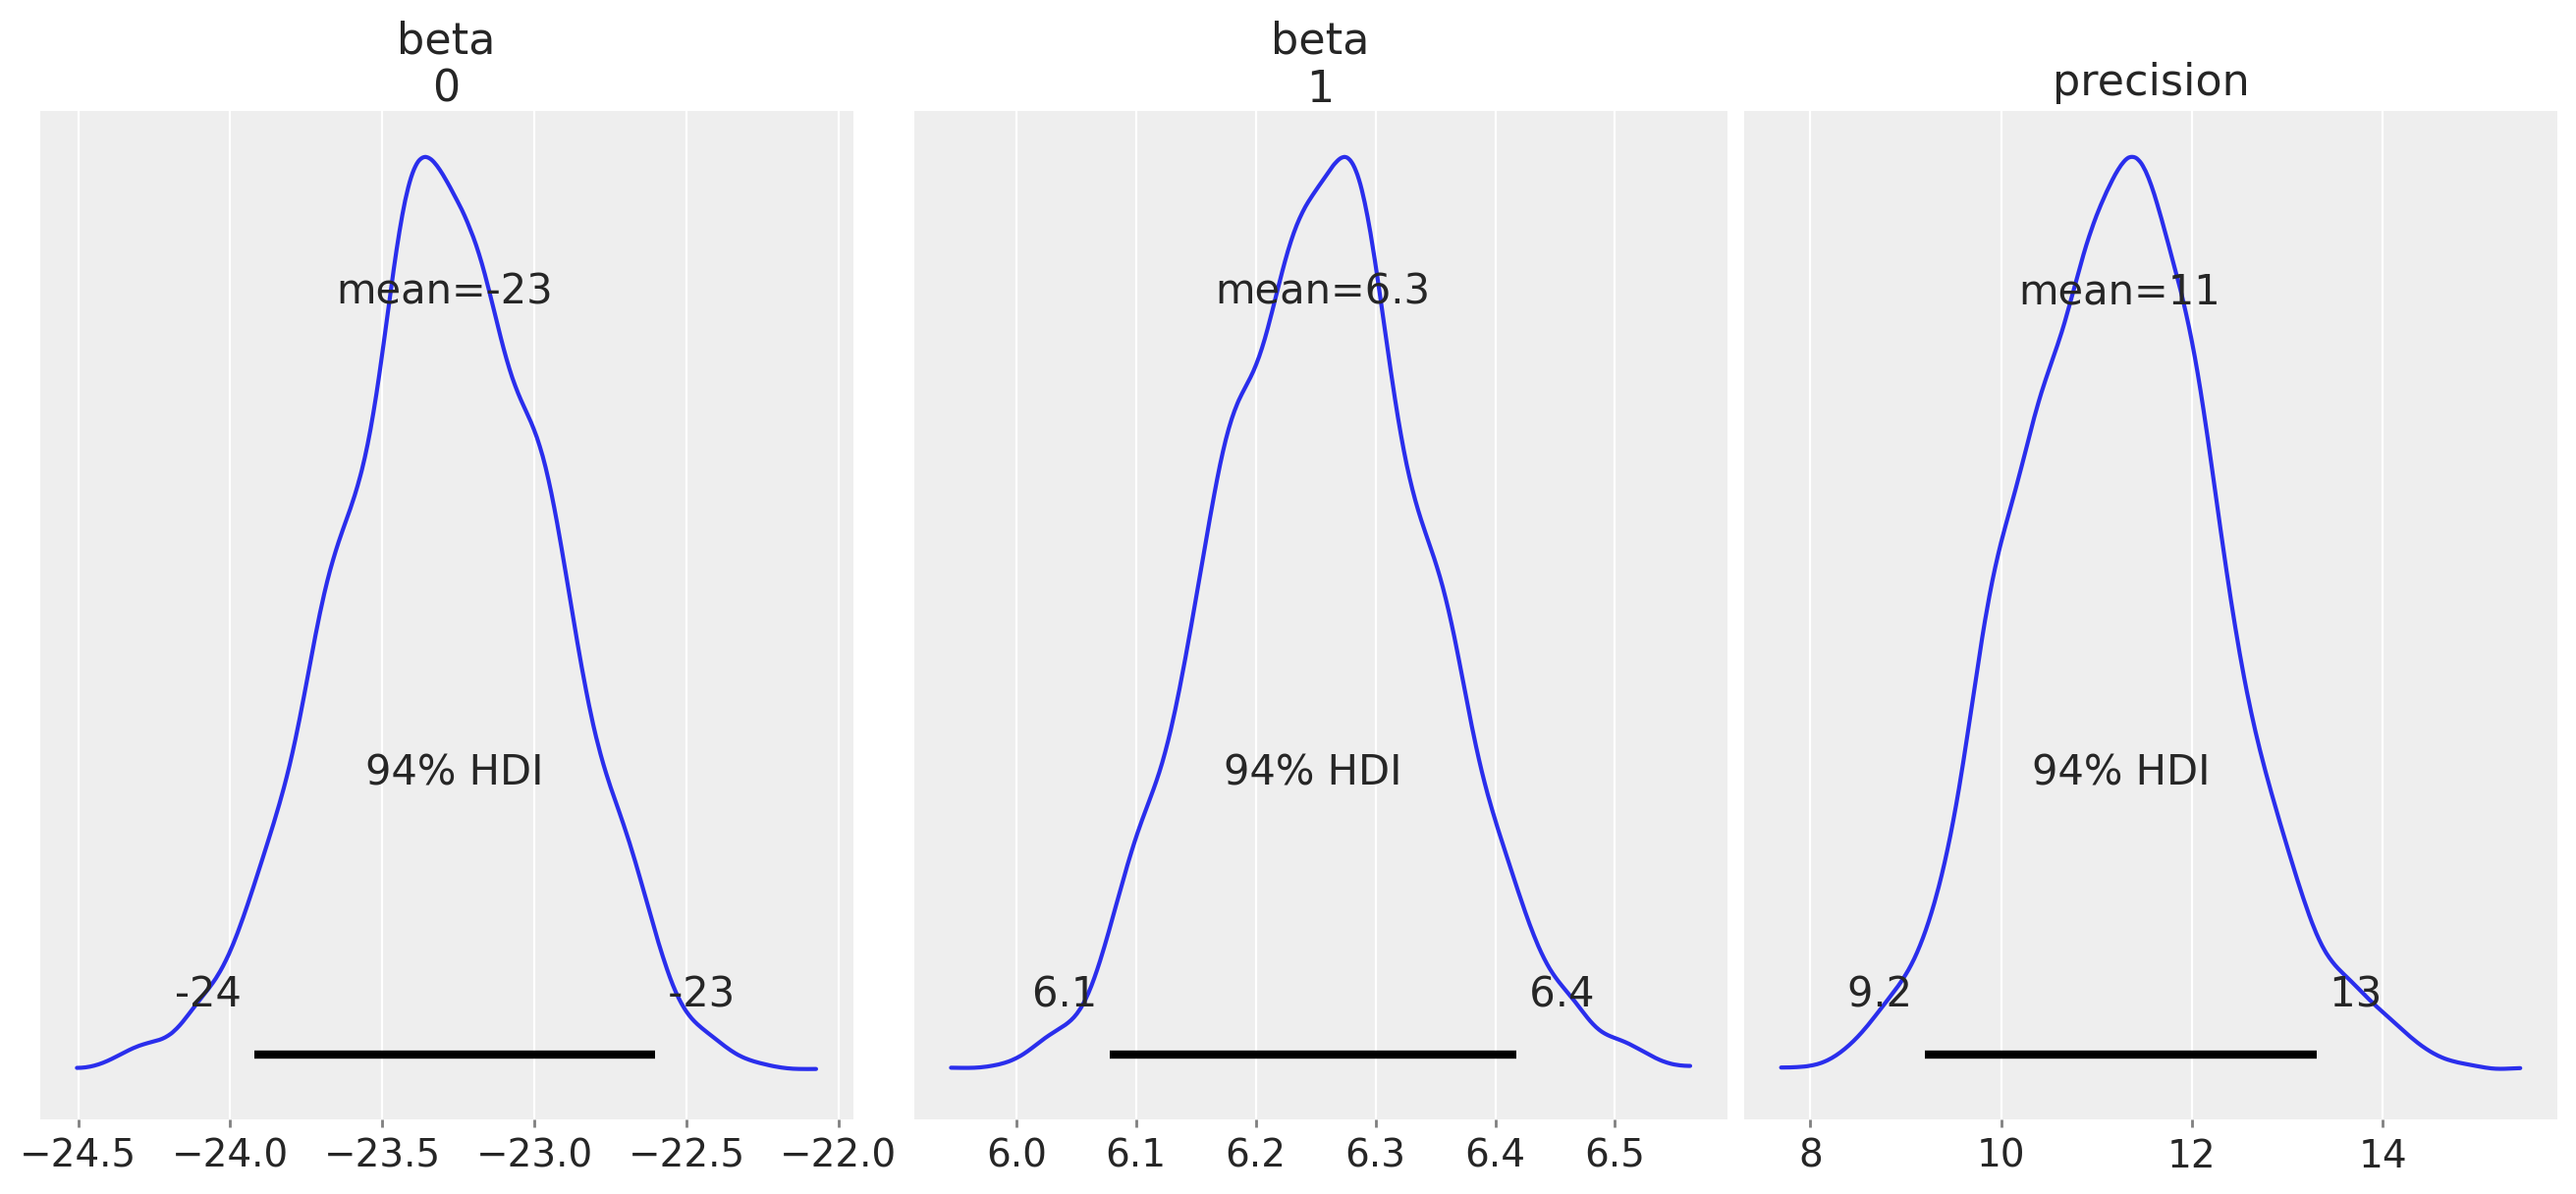

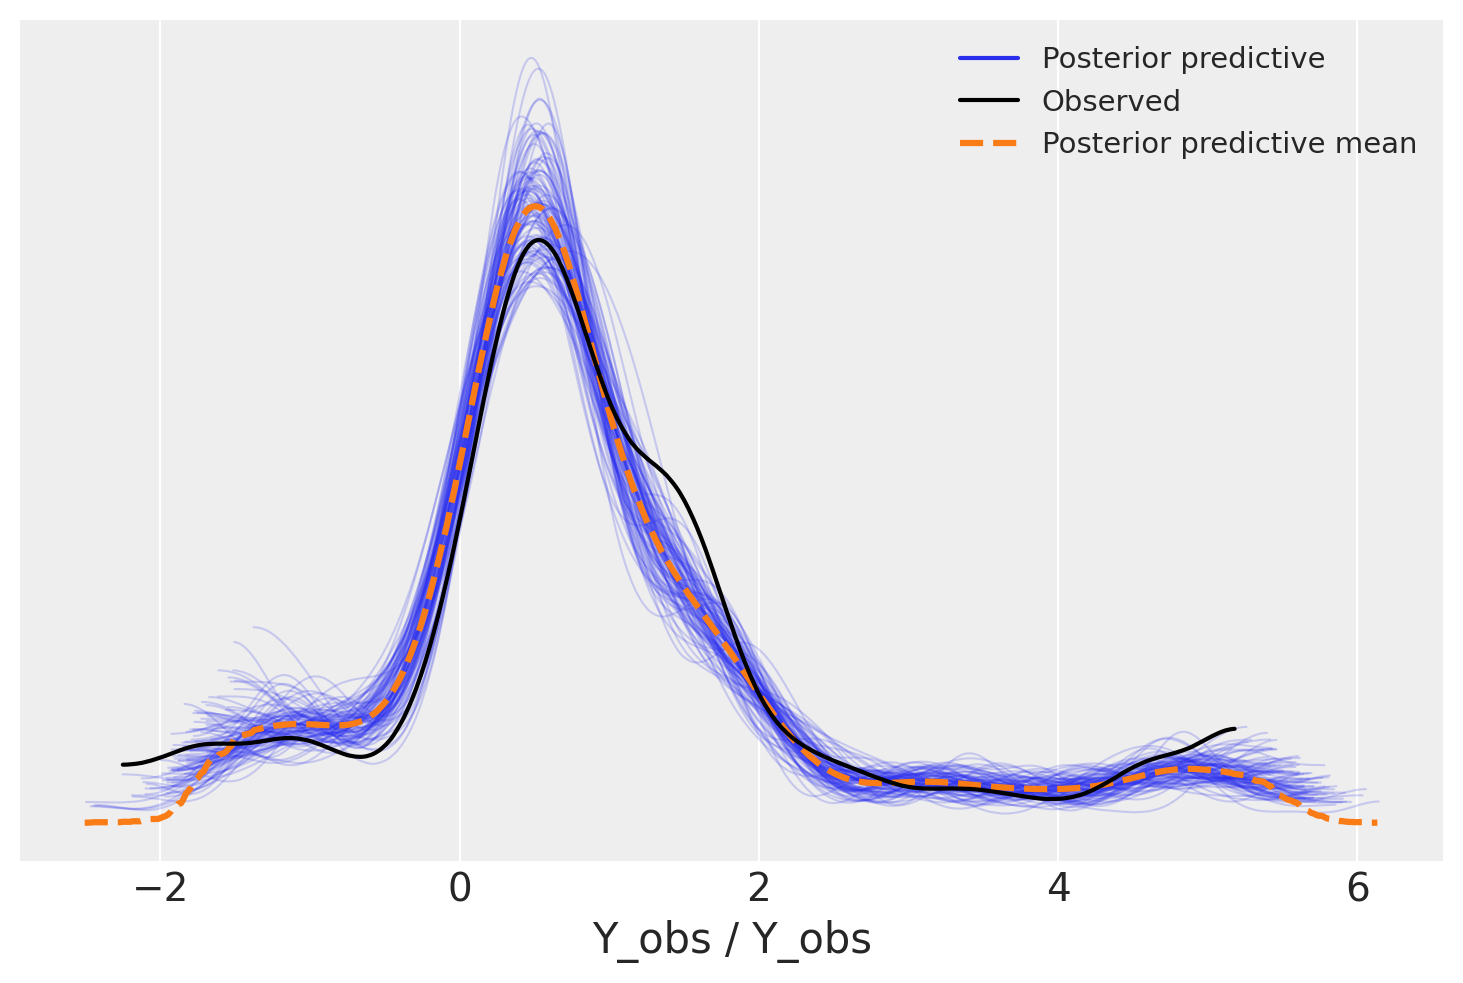

In [45]:
a=0
b=1e-1
c=0.5
d=0.5

basic_model_set2 = Model()

with basic_model_set2:
    #priors for unknown model parameters
    beta = Normal('beta', mu=a, tau=b, shape=2)
    precision = Gamma('precision', alpha=c, beta=d)
    
    #expected value of outcome
    mu = beta[0] + beta[1]*x
    
    #likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

map_estimate_set2 = find_MAP(model=basic_model_set2)

with basic_model_set2:
    start_set2 = find_MAP()
    
    #draw 1000 posterior samples
    trace_set2 = pm.sample(start=start_set2, return_inferencedata=True)

az.plot_posterior(trace_set2,figsize=(13,6))
posterior_set2 = trace_set2.posterior

with basic_model_set2:
    pm.sample_posterior_predictive(trace_set2, extend_inferencedata=True)

az.plot_ppc(trace_set2, num_pp_samples=100);

<ipython-input-40-3b33b79995f8>:25: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set3 = pm.sample(start=start_set3, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [Y_obs]


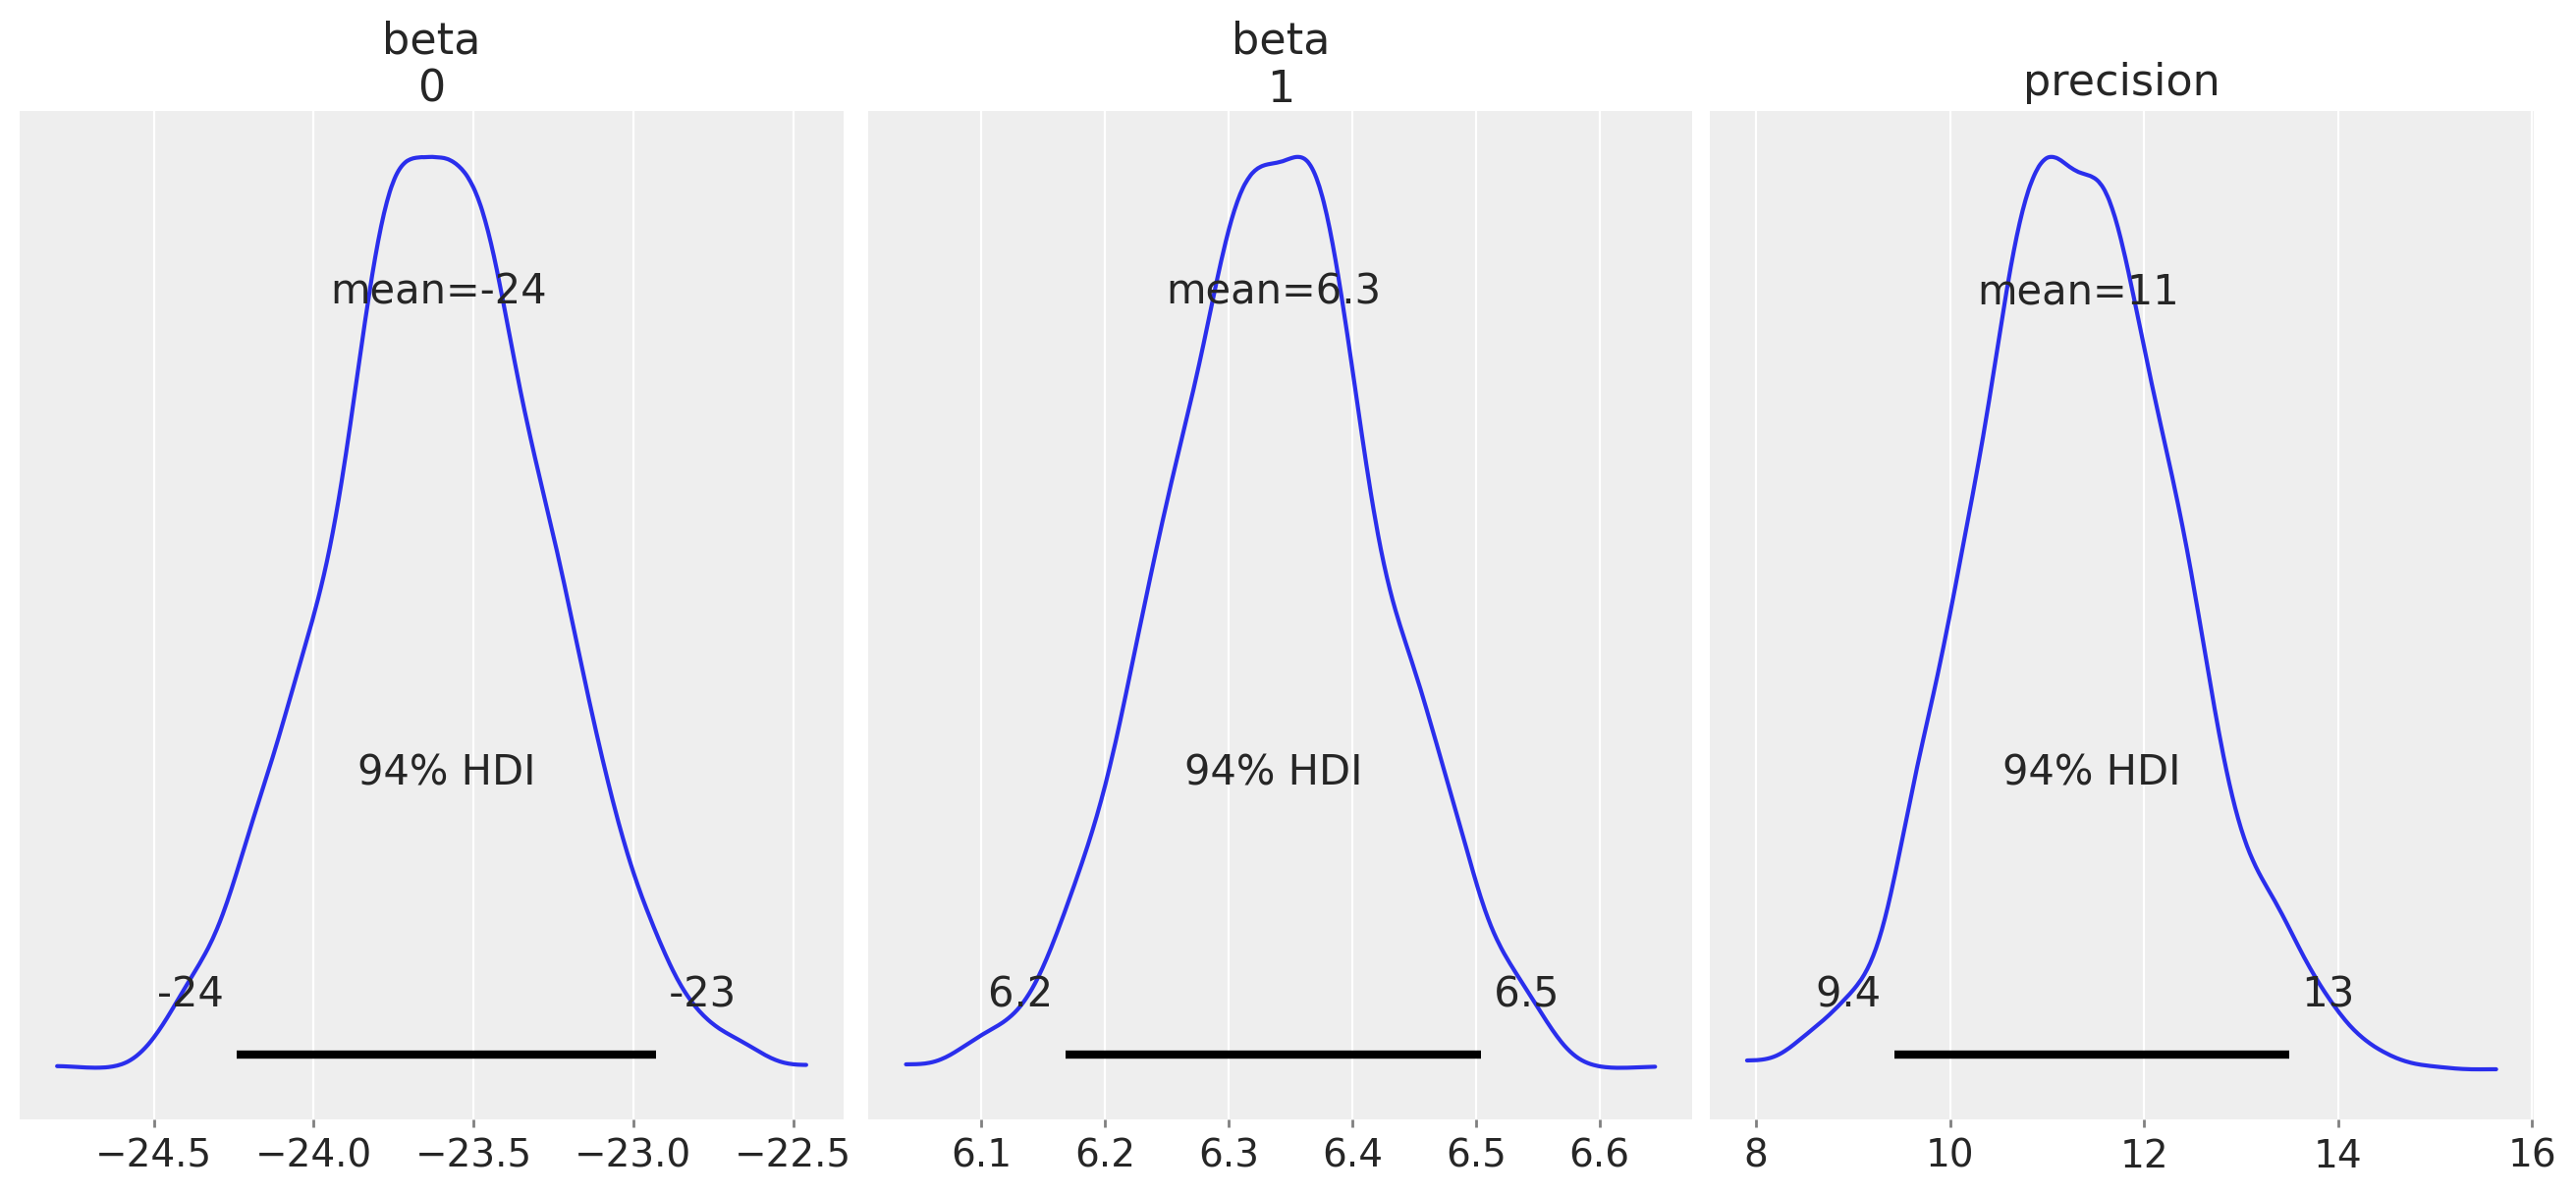

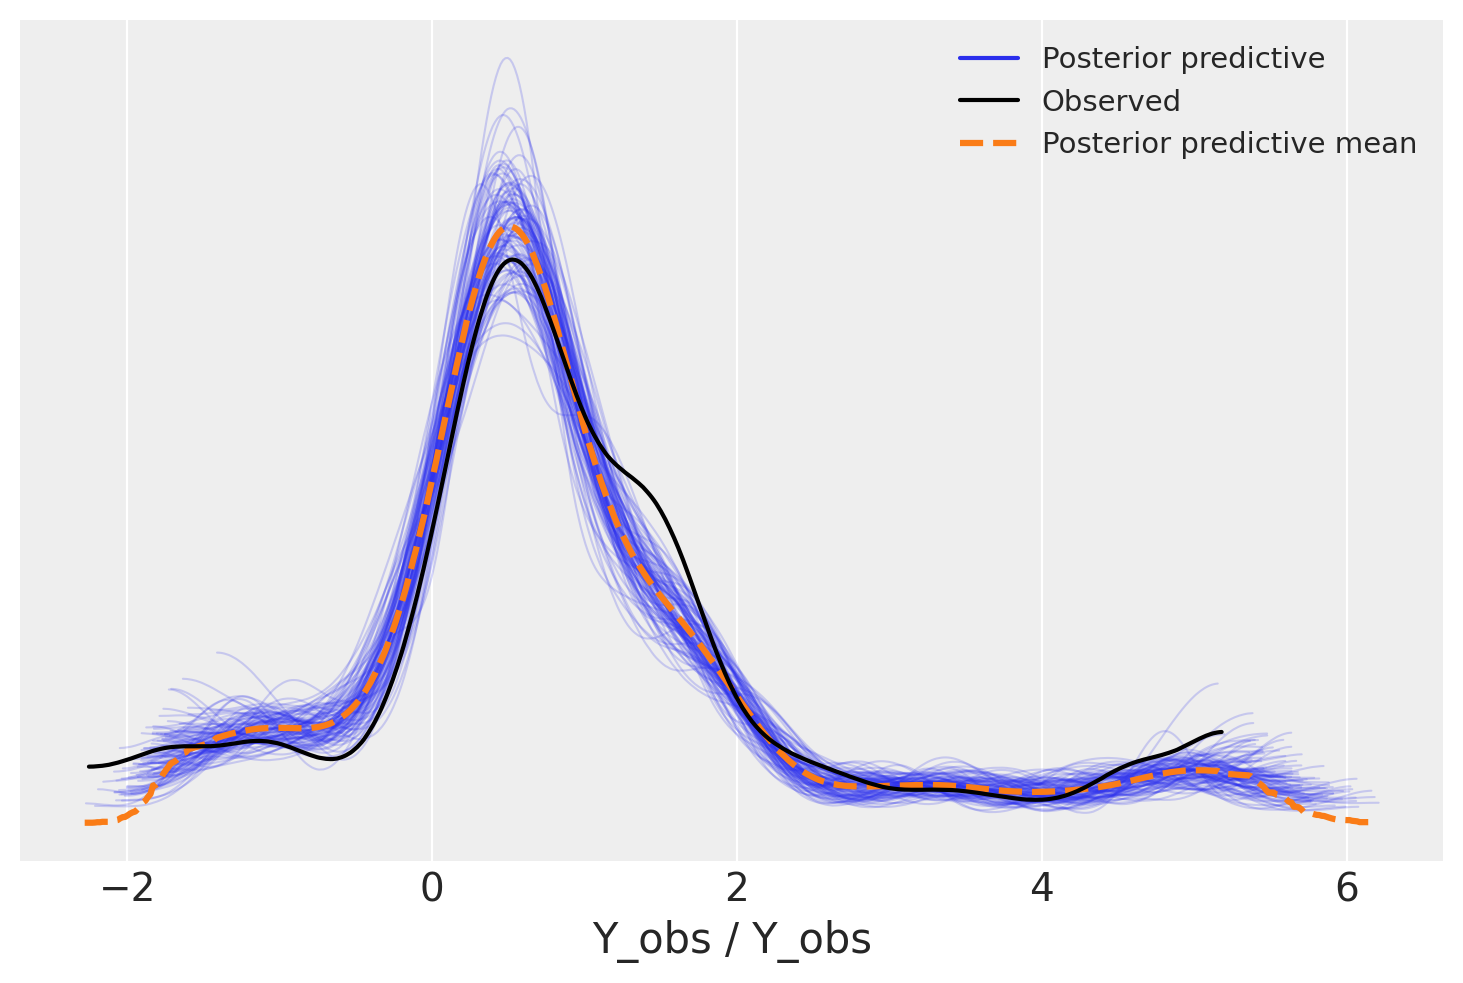

In [40]:
a=5
b=1e-3
c=0.5
d=0.5

basic_model_set3 = Model()

with basic_model_set3:
    #priors for unknown model parameters
    beta = Normal('beta', mu=a, tau=b, shape=2)
    precision = Gamma('precision', alpha=c, beta=d)
    
    #expected value of outcome
    mu = beta[0] + beta[1]*x
    
    #likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

map_estimate_set3 = find_MAP(model=basic_model_set3)

with basic_model_set3:
    start_set3 = find_MAP()
    
    #draw 1000 posterior samples
    trace_set3 = pm.sample(start=start_set3, return_inferencedata=True)

az.plot_posterior(trace_set3,figsize=(13,6))
posterior_set3 = trace_set3.posterior

with basic_model_set3:
    pm.sample_posterior_predictive(trace_set3, extend_inferencedata=True)

az.plot_ppc(trace_set3, num_pp_samples=100);

<ipython-input-46-b4586a6b886b>:25: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(start=start_set4, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [Y_obs]


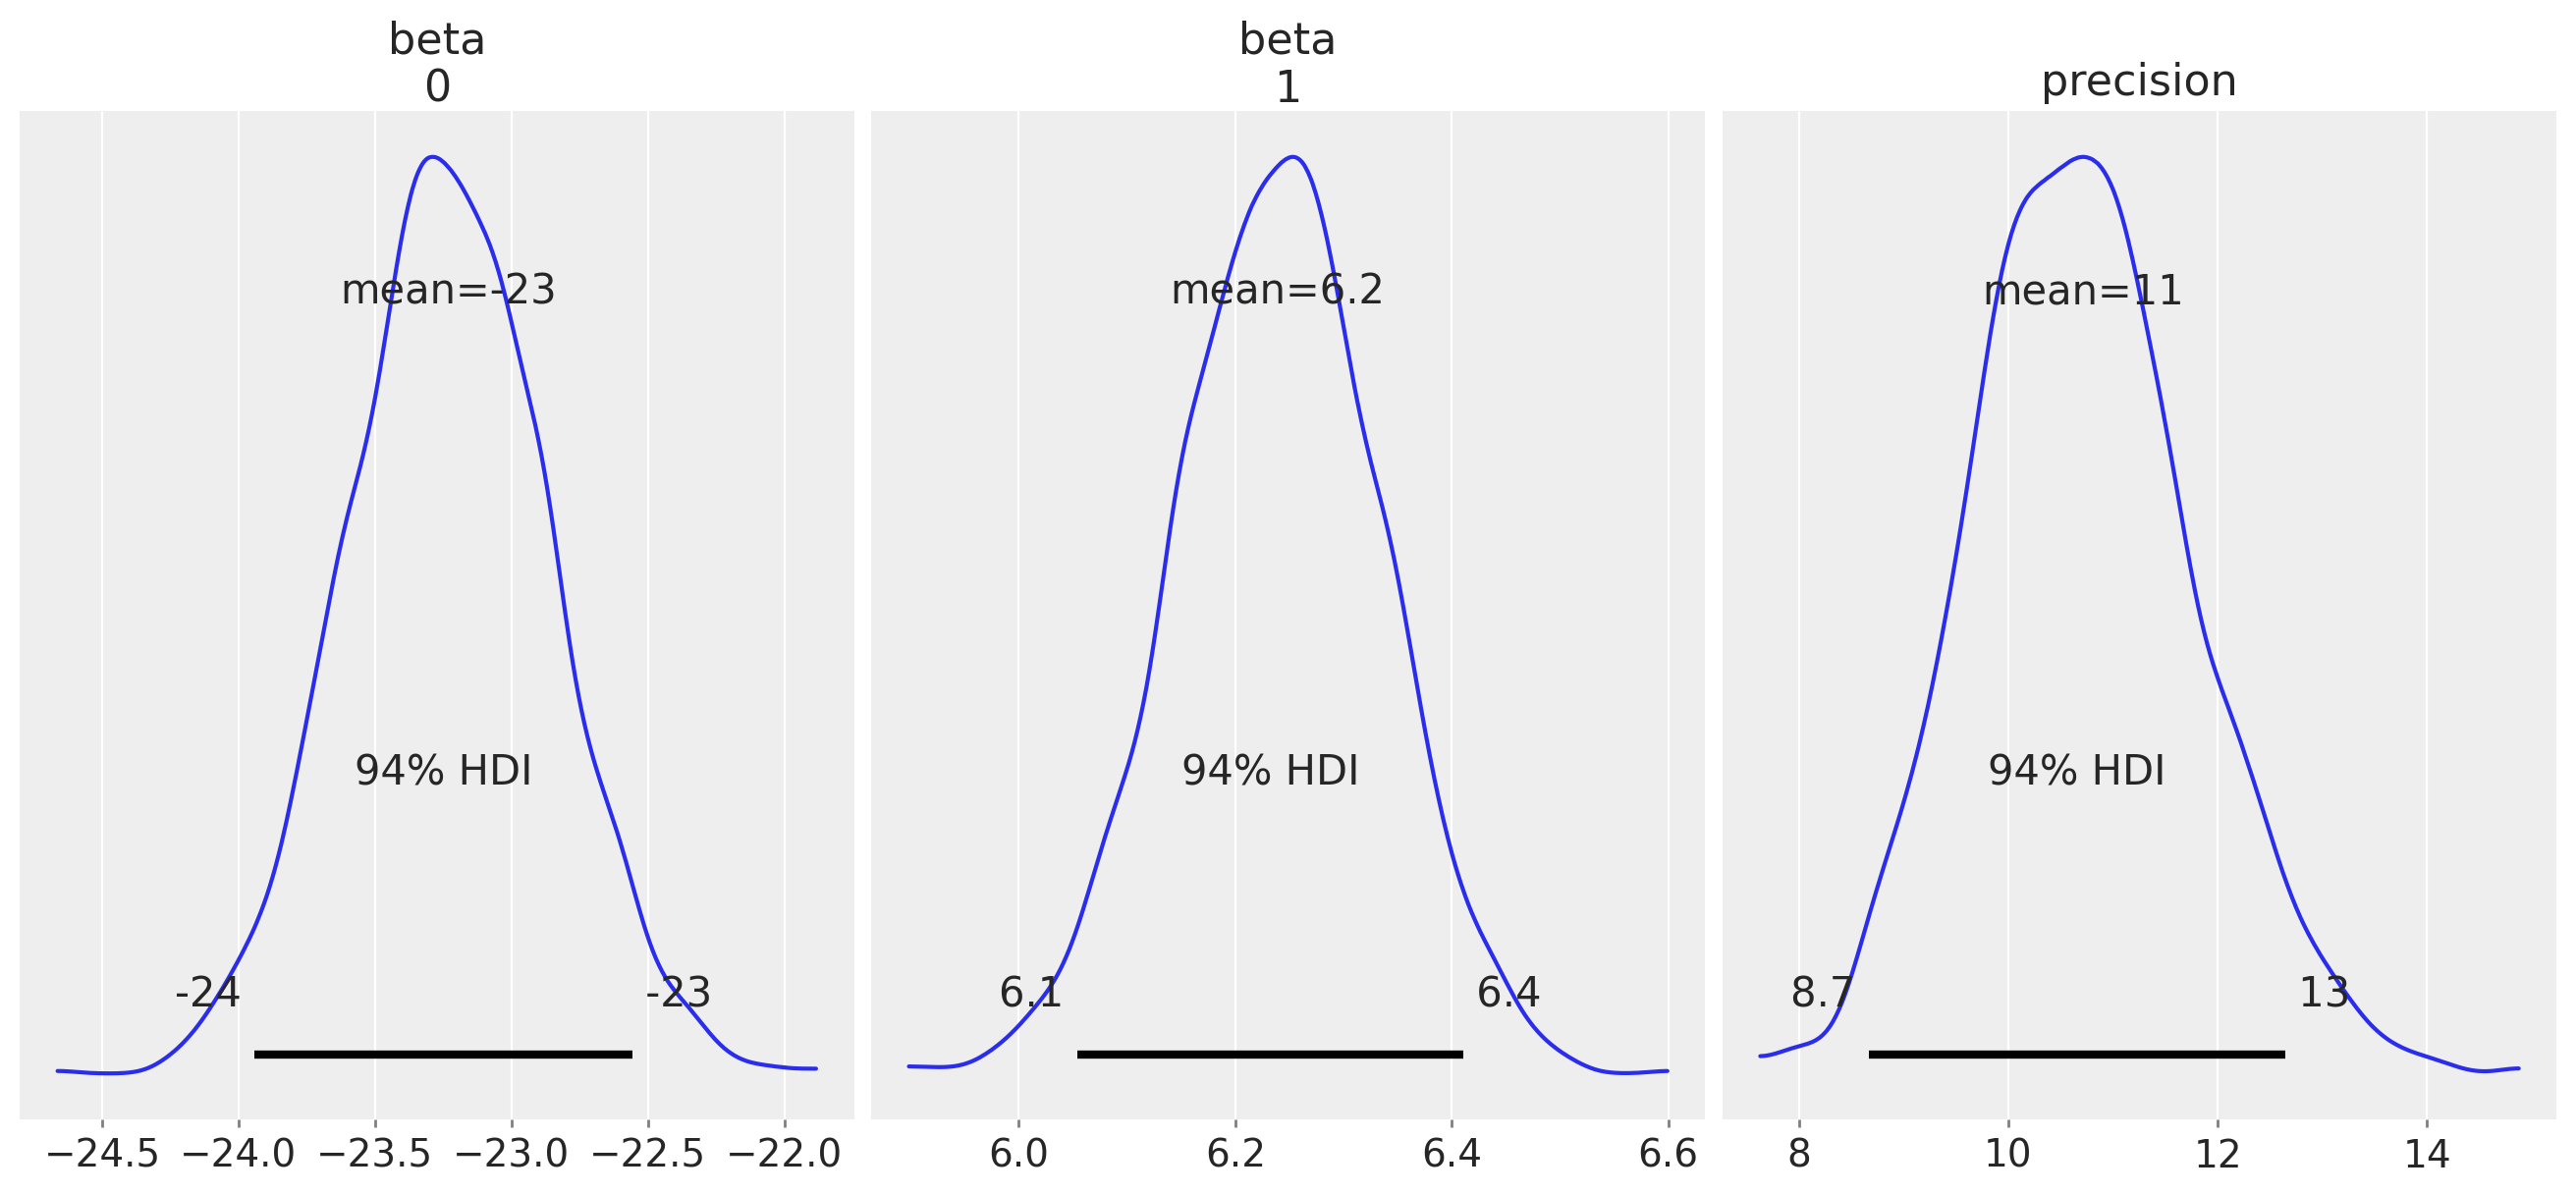

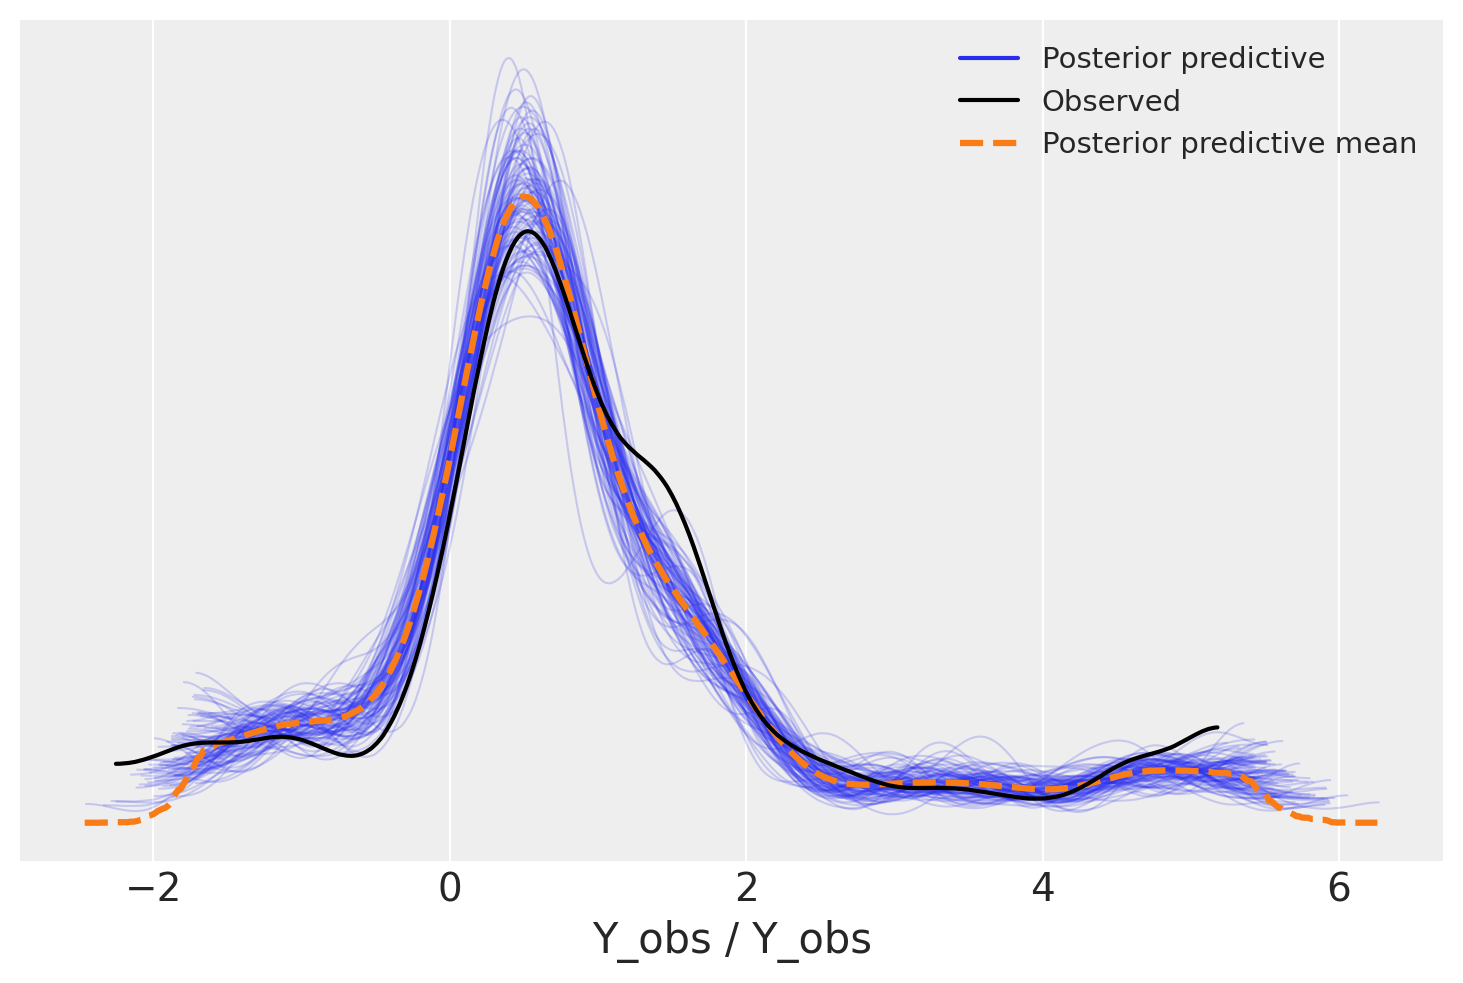

In [46]:
a=5
b=1e-1
c=1
d=1

basic_model_set4 = Model()

with basic_model_set4:
    #priors for unknown model parameters
    beta = Normal('beta', mu=a, tau=b, shape=2)
    precision = Gamma('precision', alpha=c, beta=d)
    
    #expected value of outcome
    mu = beta[0] + beta[1]*x
    
    #likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

map_estimate_set4 = find_MAP(model=basic_model_set4)

with basic_model_set4:
    start_set4 = find_MAP()
    
    #draw 1000 posterior samples
    trace_set4 = pm.sample(start=start_set4, return_inferencedata=True)

az.plot_posterior(trace_set4,figsize=(13,6))
posterior_set4 = trace_set4.posterior

with basic_model_set4:
    pm.sample_posterior_predictive(trace_set4, extend_inferencedata=True)

az.plot_ppc(trace_set4, num_pp_samples=100);

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'precision'}>], dtype=object)

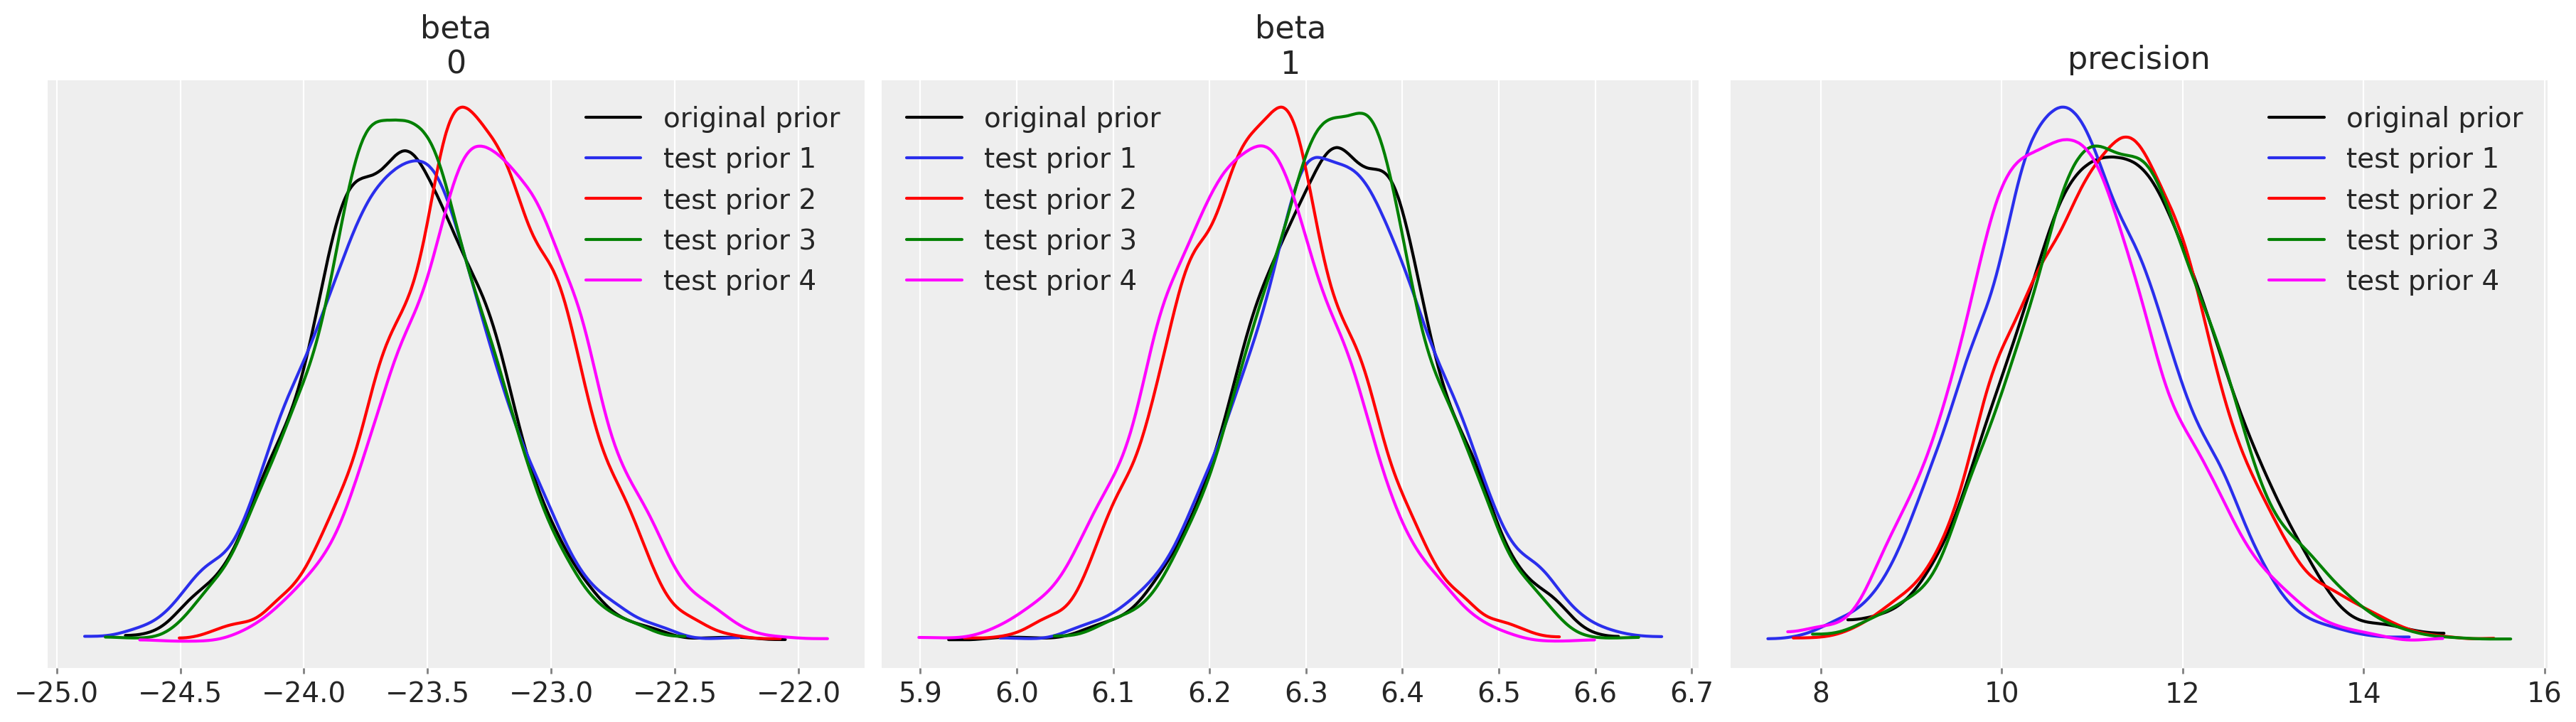

In [70]:
ax1 = az.plot_posterior(posterior, color='black', hdi_prob='hide', point_estimate=None, label='original prior', figsize=(18,5))
az.plot_posterior(posterior_set1, ax=ax1, hdi_prob='hide', point_estimate=None, label='test prior 1')
az.plot_posterior(posterior_set2, ax=ax1, color='red', hdi_prob='hide', point_estimate=None, label='test prior 2')
az.plot_posterior(posterior_set3, ax=ax1, color='green', hdi_prob='hide', point_estimate=None, label='test prior 3')
az.plot_posterior(posterior_set4, ax=ax1, color='magenta', hdi_prob='hide', point_estimate=None, label='test prior 4')

## Once more with Errors

In [34]:
basic_model2 = Model()
with basic_model2:
    #priors for unknown model parameters
    tau2 = Gamma('tau2', alpha=1, beta=1)
    X2 = Normal('X2', mu=0, tau=tau2, shape=x.shape[0])
    beta2 = Normal('beta2', mu=0, tau=1e-3, shape=2)
    #expected value
    Y2 = Normal('Y2', mu=(beta2[0]+beta2[1]*X2), tau=tau2)
    
    #likelihood (sampling distribution) of observations
    Y2_obs = Normal('Y2_obs', mu=Y2, tau=y_err**(-2), observed=y)
    x2_obs = Normal('X2_obs', mu=X2, tau=x_err**(-2), observed=x)

In [35]:
map_estimate2 = find_MAP(model=basic_model2)
map_estimate2

{'tau2_log__': array(-2.02331793),
 'X2': array([3.48291229, 3.49588367, 3.50997079, 3.51495349, 3.48553712,
        3.51286655, 3.52797822, 3.49967451, 3.5038374 , 3.53860284,
        3.51800006, 3.57196795, 3.52188485, 3.59290672, 3.5718932 ,
        3.60497278, 3.58191942, 3.59287426, 3.62792887, 3.62373786,
        3.79598104, 3.6229312 , 3.69878295, 3.78393422, 3.789962  ,
        3.62277007, 3.78496029, 3.77197716, 3.79298463, 3.78694635,
        3.67688546, 3.78895838, 3.72581087, 3.77999464, 3.77499522,
        3.74892273, 3.72797756, 3.70189601, 3.7599651 , 3.72084865,
        3.76394768, 3.73995972, 3.75095671, 3.75395908, 3.776964  ,
        3.6499606 , 3.78699585, 3.7599381 , 3.76292381, 3.77195342,
        3.77097475, 3.77296814, 3.76399314, 3.77495696, 3.76697909,
        3.77298663, 3.7819833 , 3.77097883, 3.78797049, 3.77794083,
        3.77096835, 3.7749886 , 3.80099556, 3.78098702, 3.80399121,
        3.7829707 , 3.77799036, 3.79293206, 3.79199759, 3.76389024,
       

In [36]:
with basic_model2:
    start2 = find_MAP()
    
    #draw 1000 posterior samples
    trace2 = pm.sample(start=start2, return_inferencedata=True)

<ipython-input-36-2d1478bd4e8d>:5: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace2 = pm.sample(start=start2, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau2, X2, beta2, Y2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [37]:
az.summary(trace2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
X2[0]    3.483  0.011   3.463    3.504      0.000    0.000    6414.0   
X2[1]    3.496  0.010   3.478    3.515      0.000    0.000    6521.0   
X2[2]    3.510  0.005   3.501    3.520      0.000    0.000    5968.0   
X2[3]    3.515  0.013   3.491    3.540      0.000    0.000    5592.0   
X2[4]    3.485  0.024   3.439    3.530      0.000    0.000    6103.0   
...        ...    ...     ...      ...        ...      ...       ...   
Y2[208]  5.019  0.100   4.834    5.206      0.001    0.001    6158.0   
Y2[209]  5.179  0.053   5.080    5.277      0.001    0.000    6103.0   
Y2[210]  5.188  0.121   4.963    5.423      0.002    0.001    5999.0   
Y2[211]  5.087  0.029   5.030    5.140      0.000    0.000    4069.0   
tau2     0.132  0.009   0.114    0.148      0.000    0.000    6067.0   

         ess_tail  r_hat  
X2[0]      3040.0    1.0  
X2[1]      2352.0    1.0  
X2[2]      2933.0    1.0  
X2[3]      2438.0    1.0  
X2[4]      2804.0    1.0  
...           ...    ...  
Y2[208]    3103.0    1.0  
Y2[209]    3182.0    1.0  
Y2[210]    3401.0    1.0  
Y2[211]    2973.0    1.0  
tau2       2888.0    1.0  

[427 rows x 9 columns]

In [38]:
#get the posterior dataset
posterior2 = trace2.posterior
posterior2

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, X2_dim_0: 212, beta2_dim_0: 2,
                  Y2_dim_0: 212)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * X2_dim_0     (X2_dim_0) int64 0 1 2 3 4 5 6 ... 205 206 207 208 209 210 211
  * beta2_dim_0  (beta2_dim_0) int64 0 1
  * Y2_dim_0     (Y2_dim_0) int64 0 1 2 3 4 5 6 ... 205 206 207 208 209 210 211
Data variables:
    X2           (chain, draw, X2_dim_0) float64 3.491 3.51 ... 4.567 4.594
    beta2        (chain, draw, beta2_dim_0) float64 -24.29 6.561 ... 7.132
    Y2           (chain, draw, Y2_dim_0) float64 -1.826 -2.235 ... 5.193 5.074
    tau2         (chain, draw) float64 0.1287 0.1317 0.129 ... 0.1489 0.1359
Attributes:
    created_at:                 2022-11-16T21:57:23.083886
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              16.54956364631653
    tuning_steps:               1000

array([[<AxesSubplot:title={'center':'tau2'}>,
        <AxesSubplot:title={'center':'tau2'}>]], dtype=object)

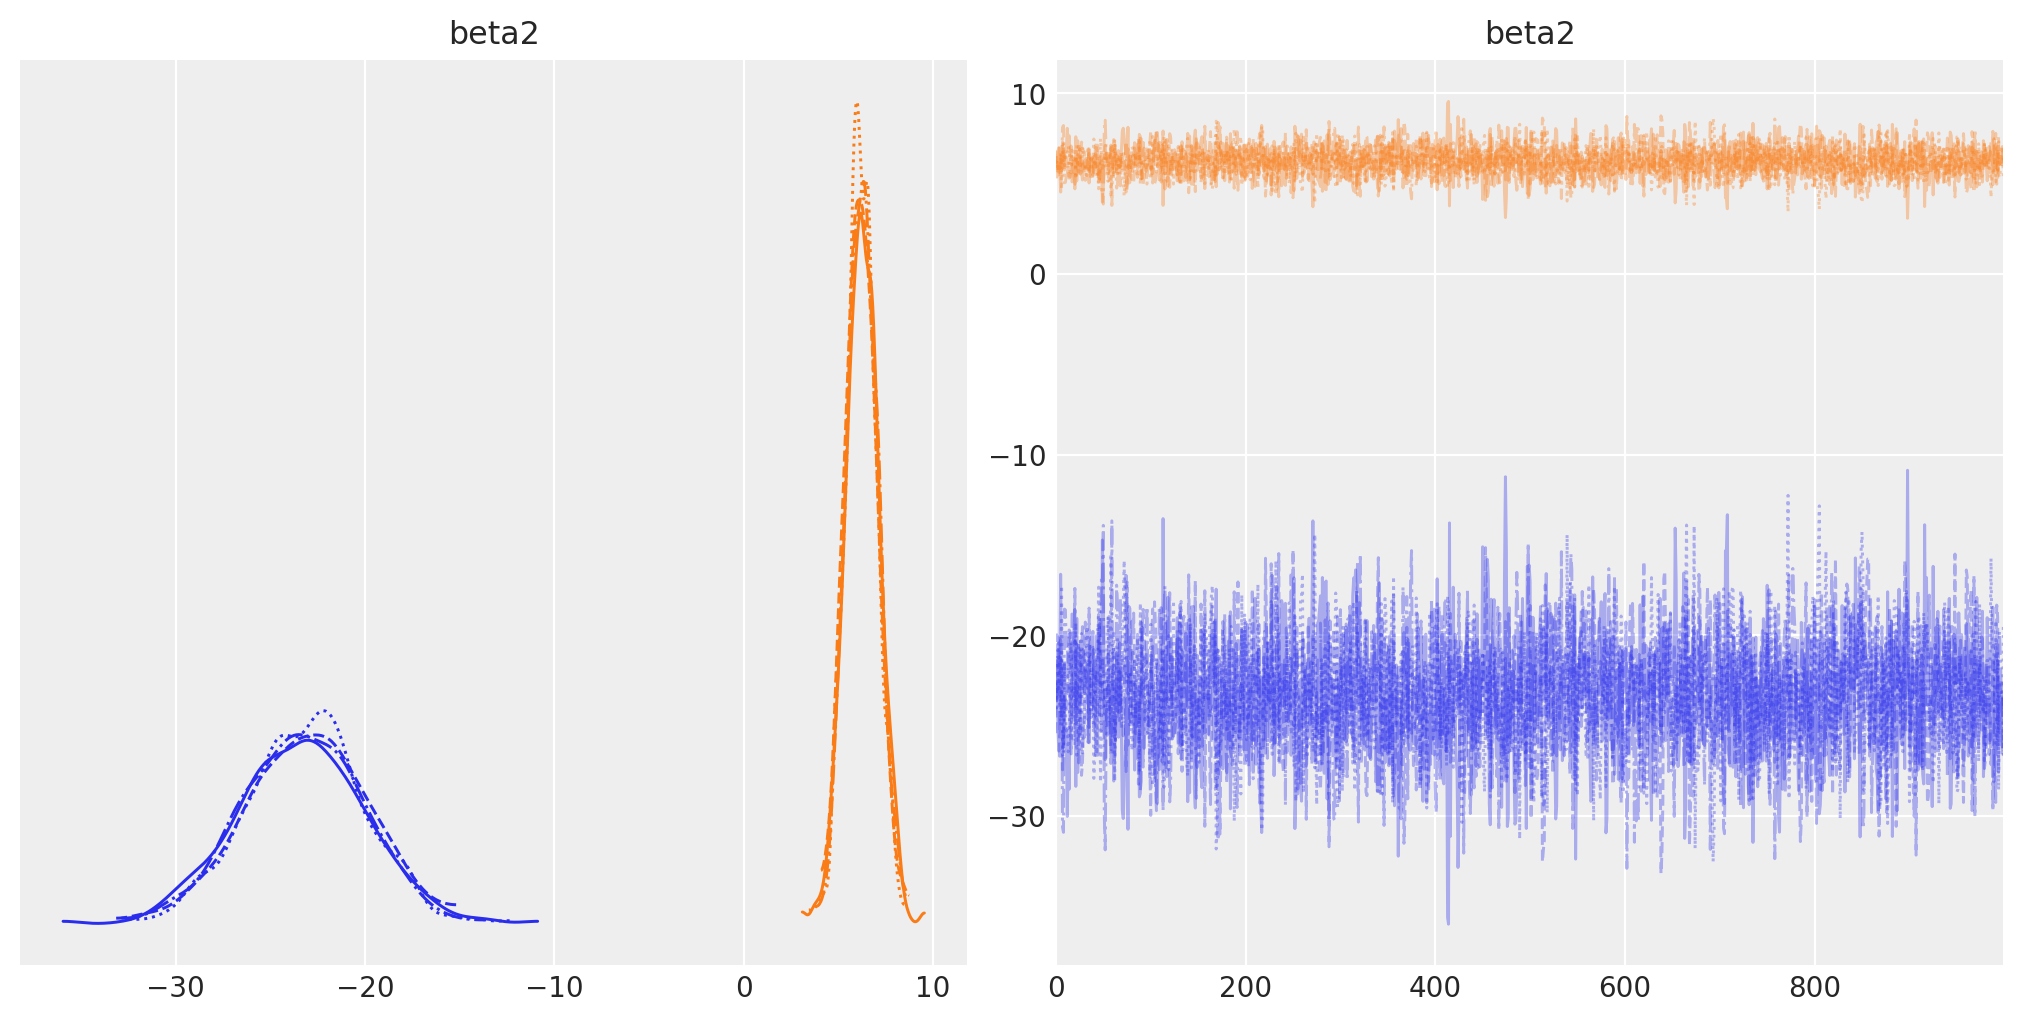

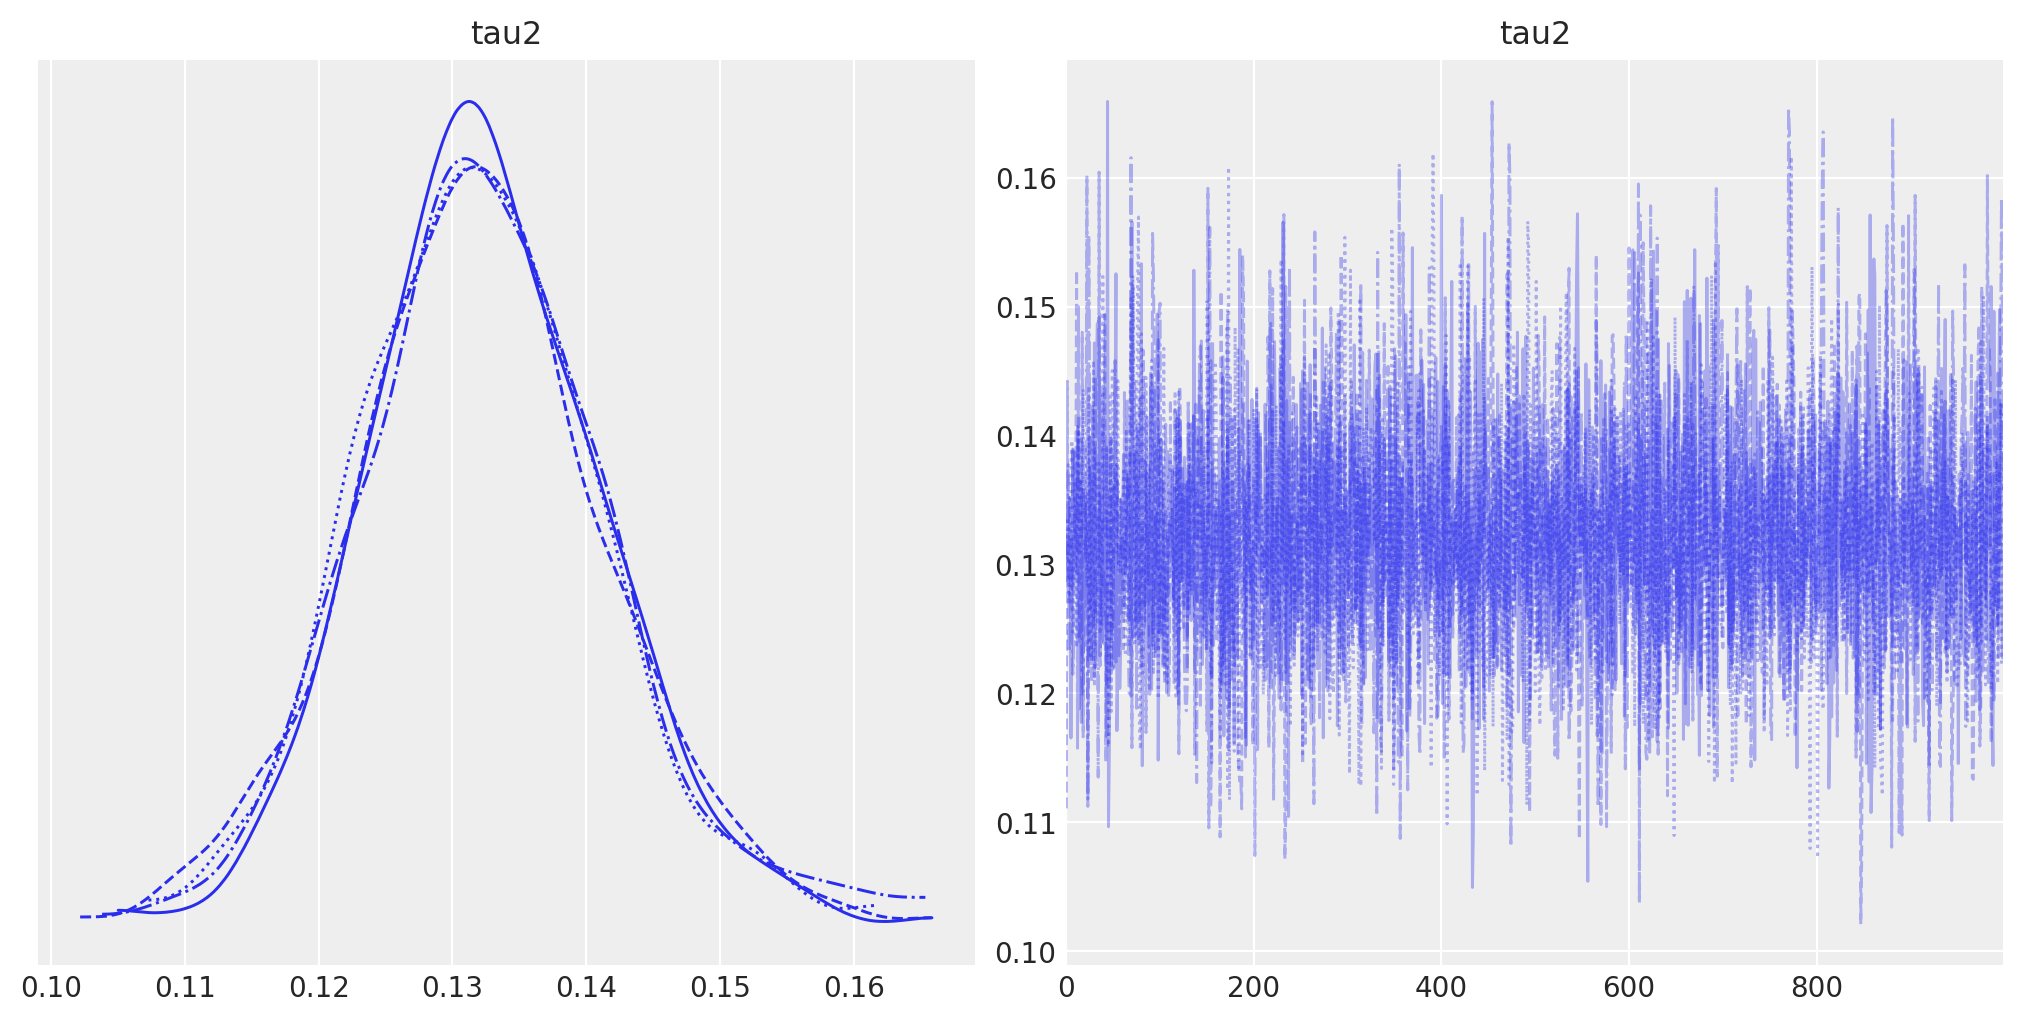

In [39]:
az.plot_trace(trace2.posterior['beta2'], figsize=(10,5))
az.plot_trace(trace2.posterior['tau2'], figsize=(10,5))

array([<AxesSubplot:title={'center':'beta2\n0'}>,
       <AxesSubplot:title={'center':'beta2\n1'}>,
       <AxesSubplot:title={'center':'tau2'}>], dtype=object)

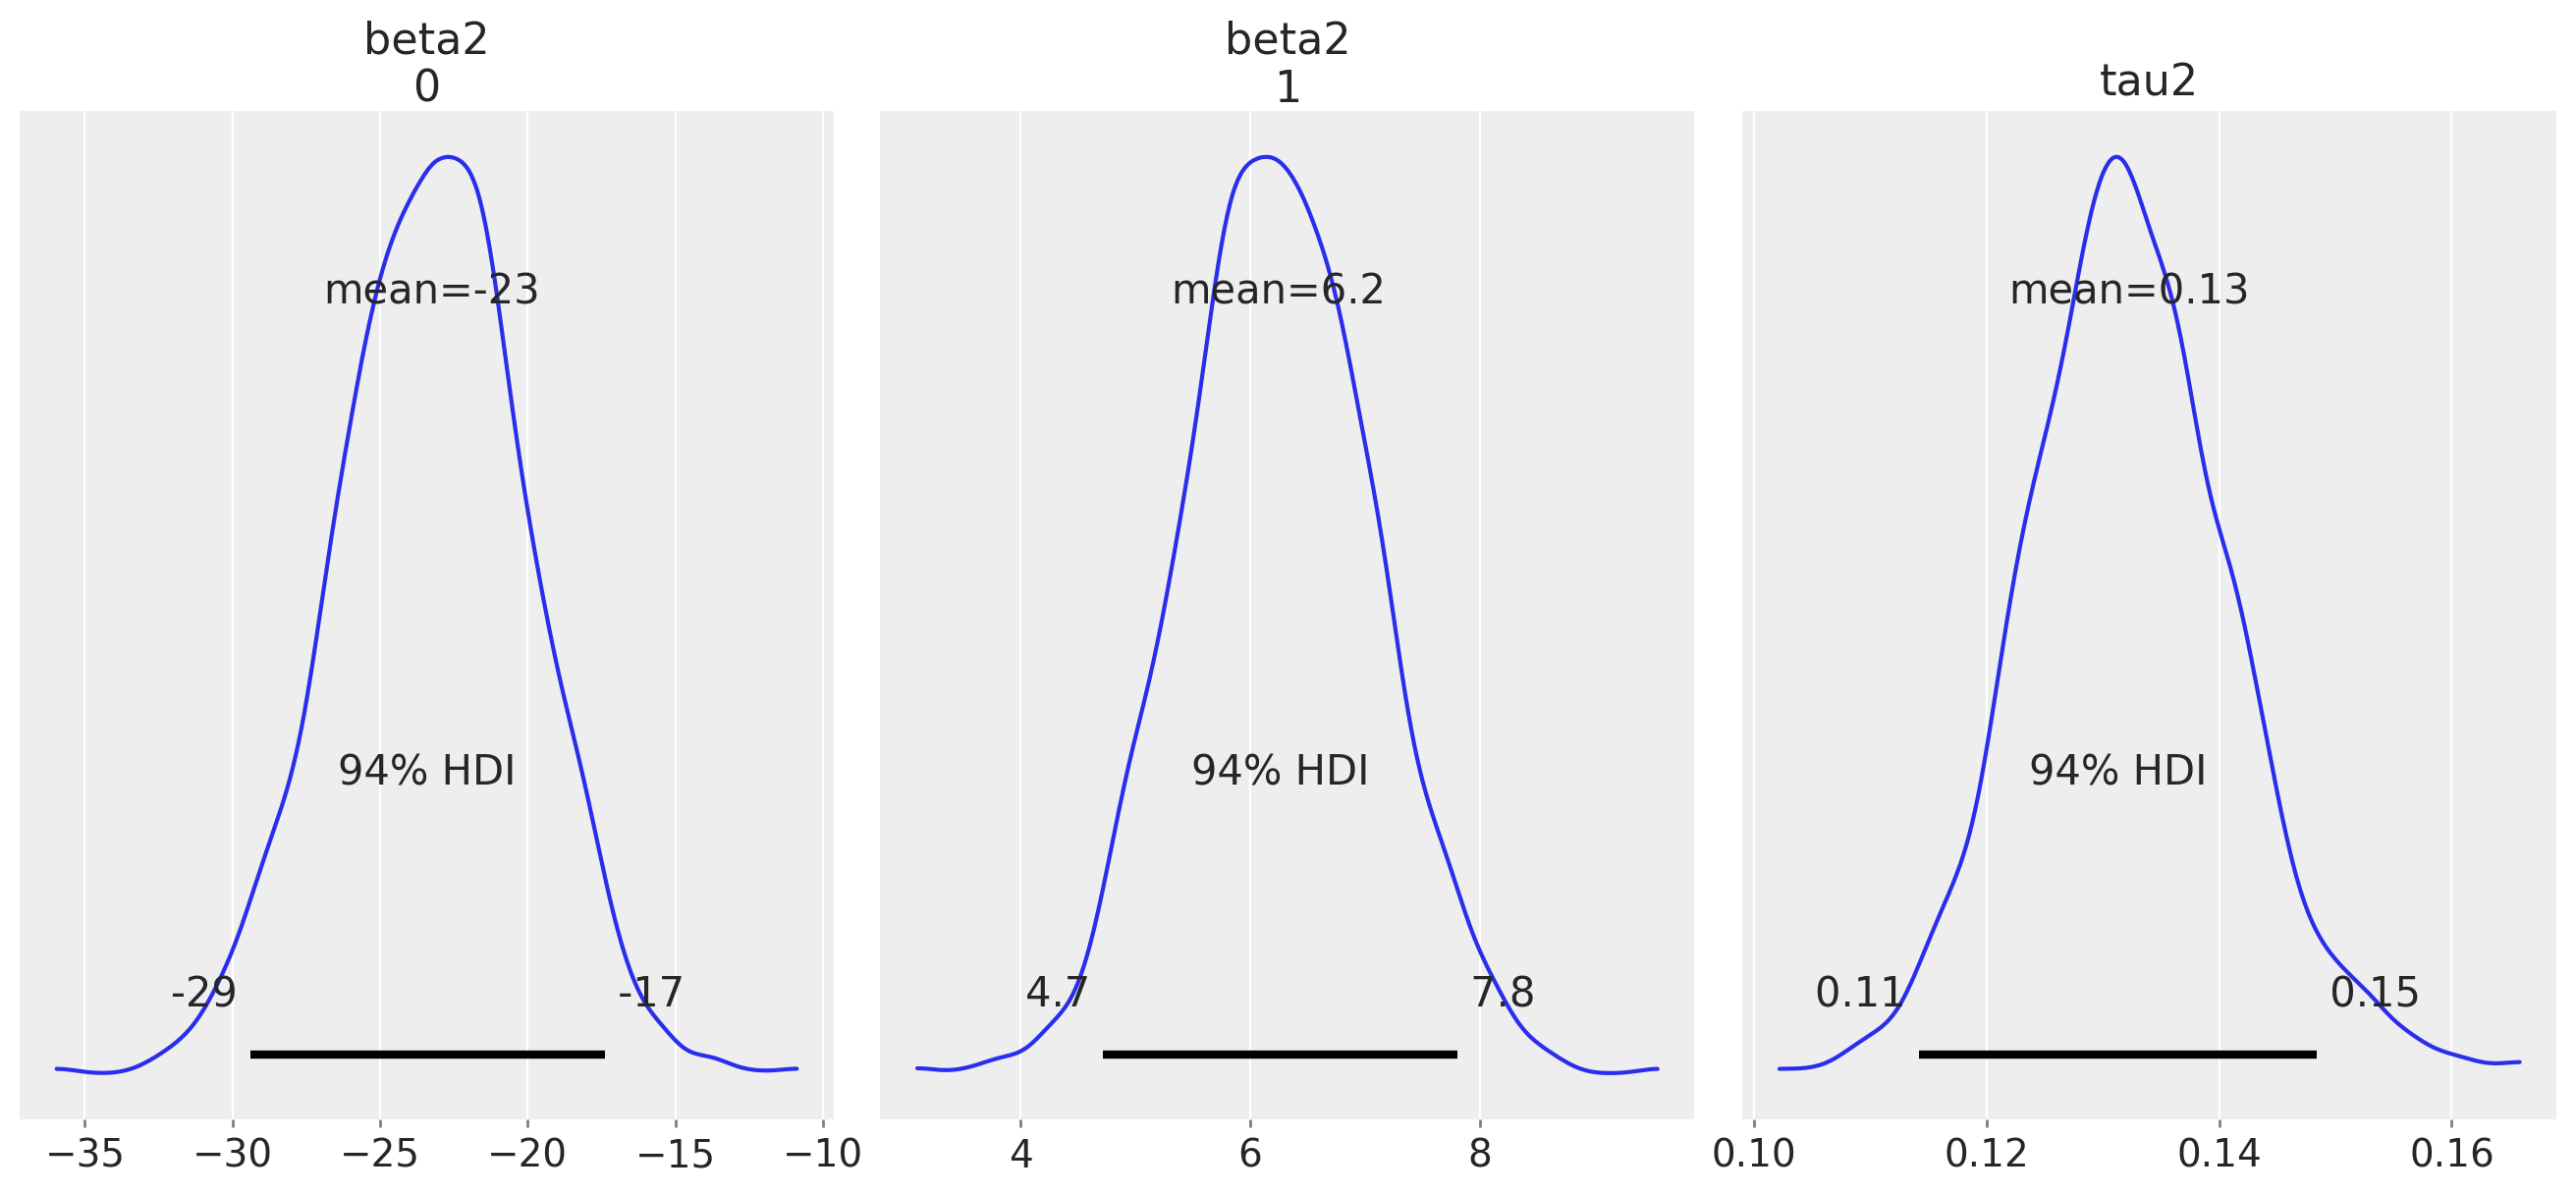

In [40]:
az.plot_posterior(trace2.posterior[['beta2','tau2']], figsize=(13,6))

array([<AxesSubplot:title={'center':'beta2\n0'}>,
       <AxesSubplot:title={'center':'beta2\n1'}>], dtype=object)

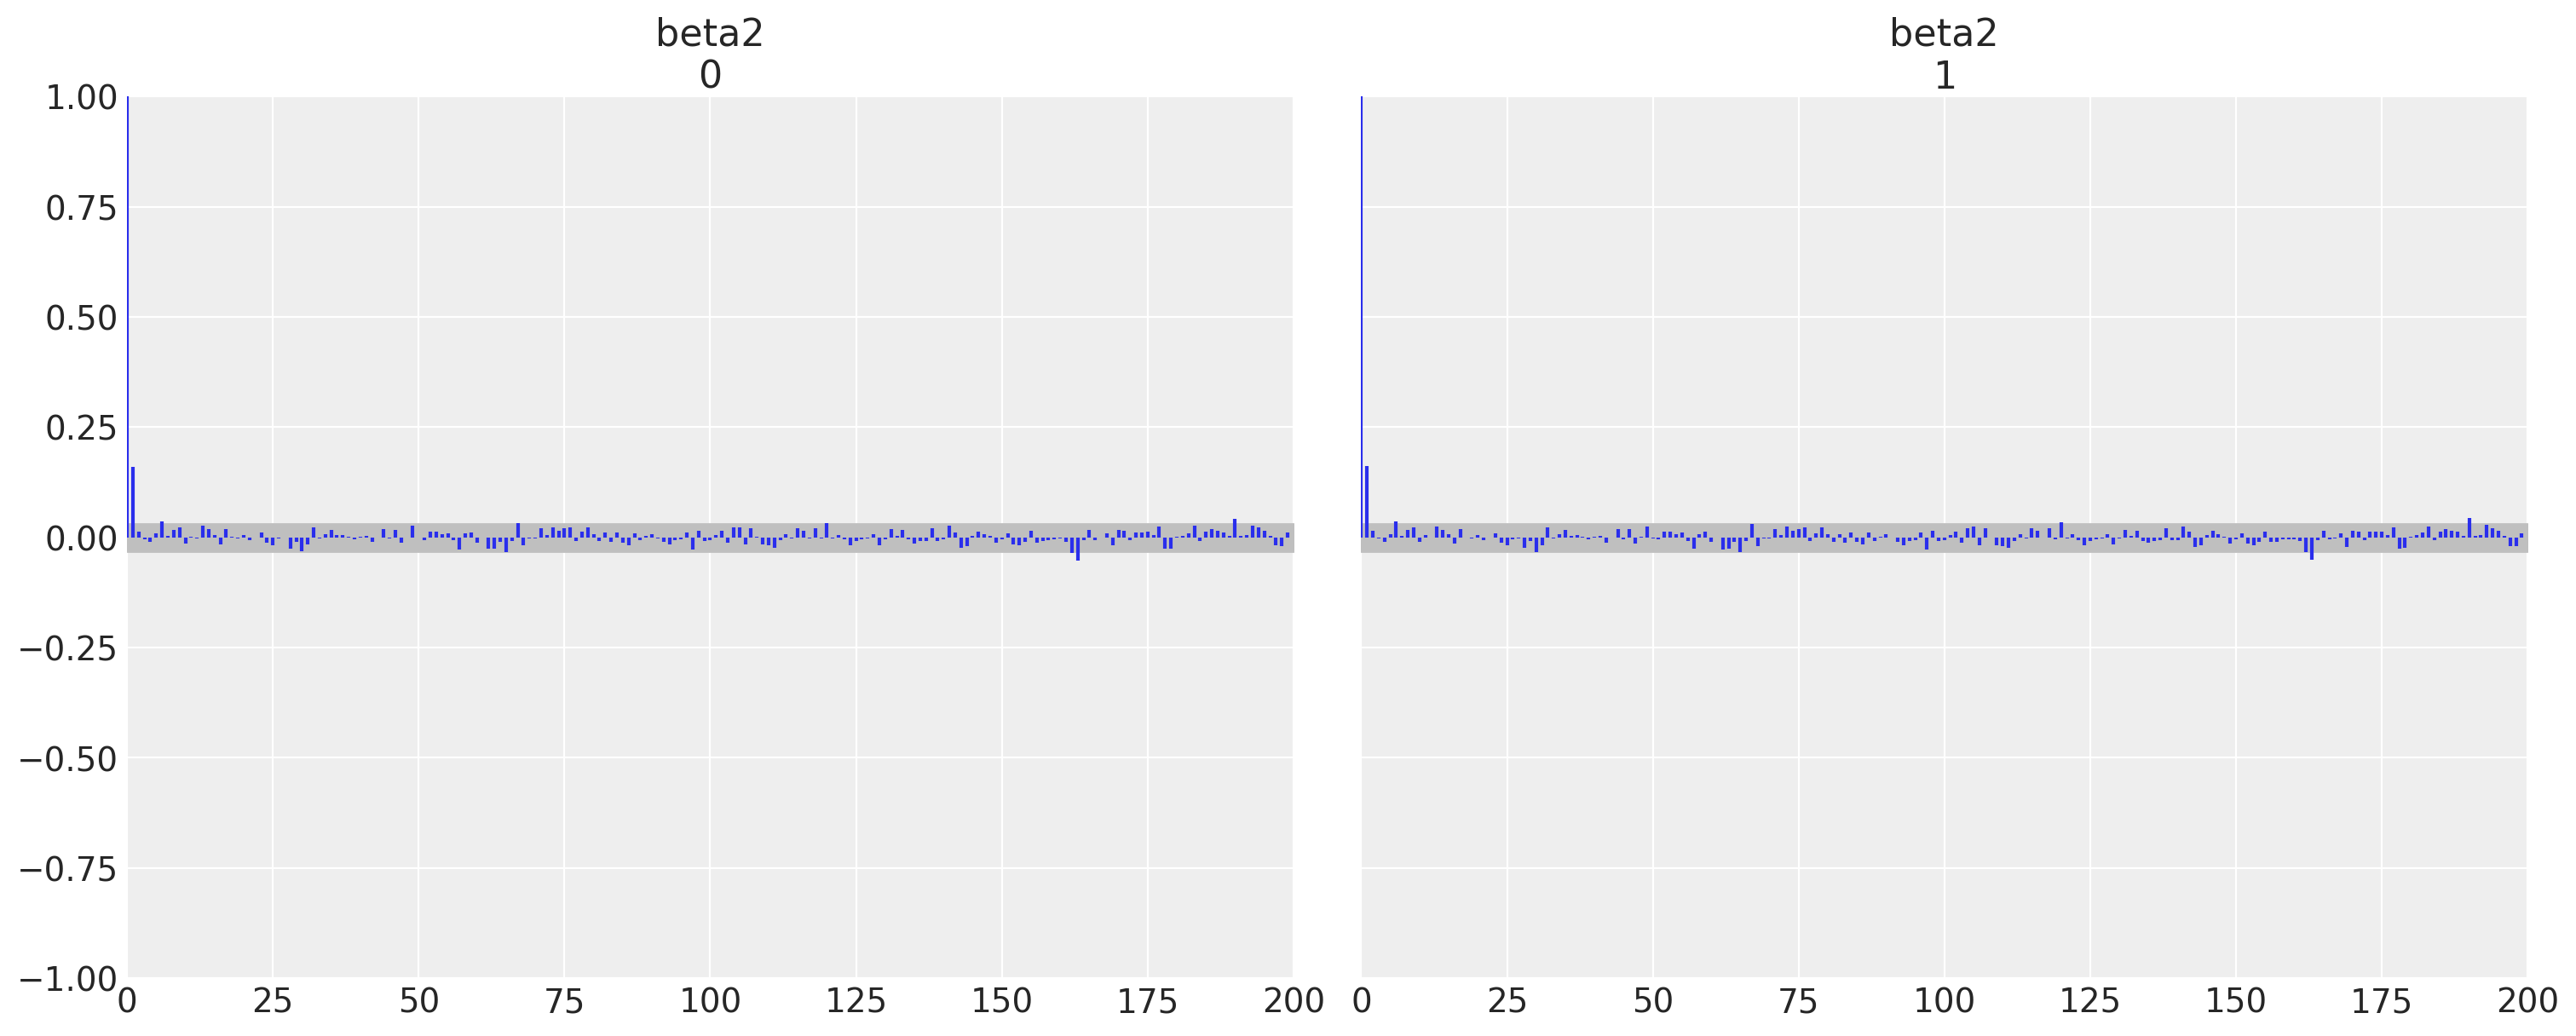

In [41]:
az.plot_autocorr(trace2, var_names=['beta2'], filter_vars='like', max_lag=200, combined=True, figsize=(15,6))

In [42]:
with basic_model2:
    pm.sample_posterior_predictive(trace2, extend_inferencedata=True)

Sampling: [X2_obs, Y2_obs]


array([<AxesSubplot:xlabel='Y2_obs / Y2_obs'>,
       <AxesSubplot:xlabel='X2_obs / X2_obs'>], dtype=object)

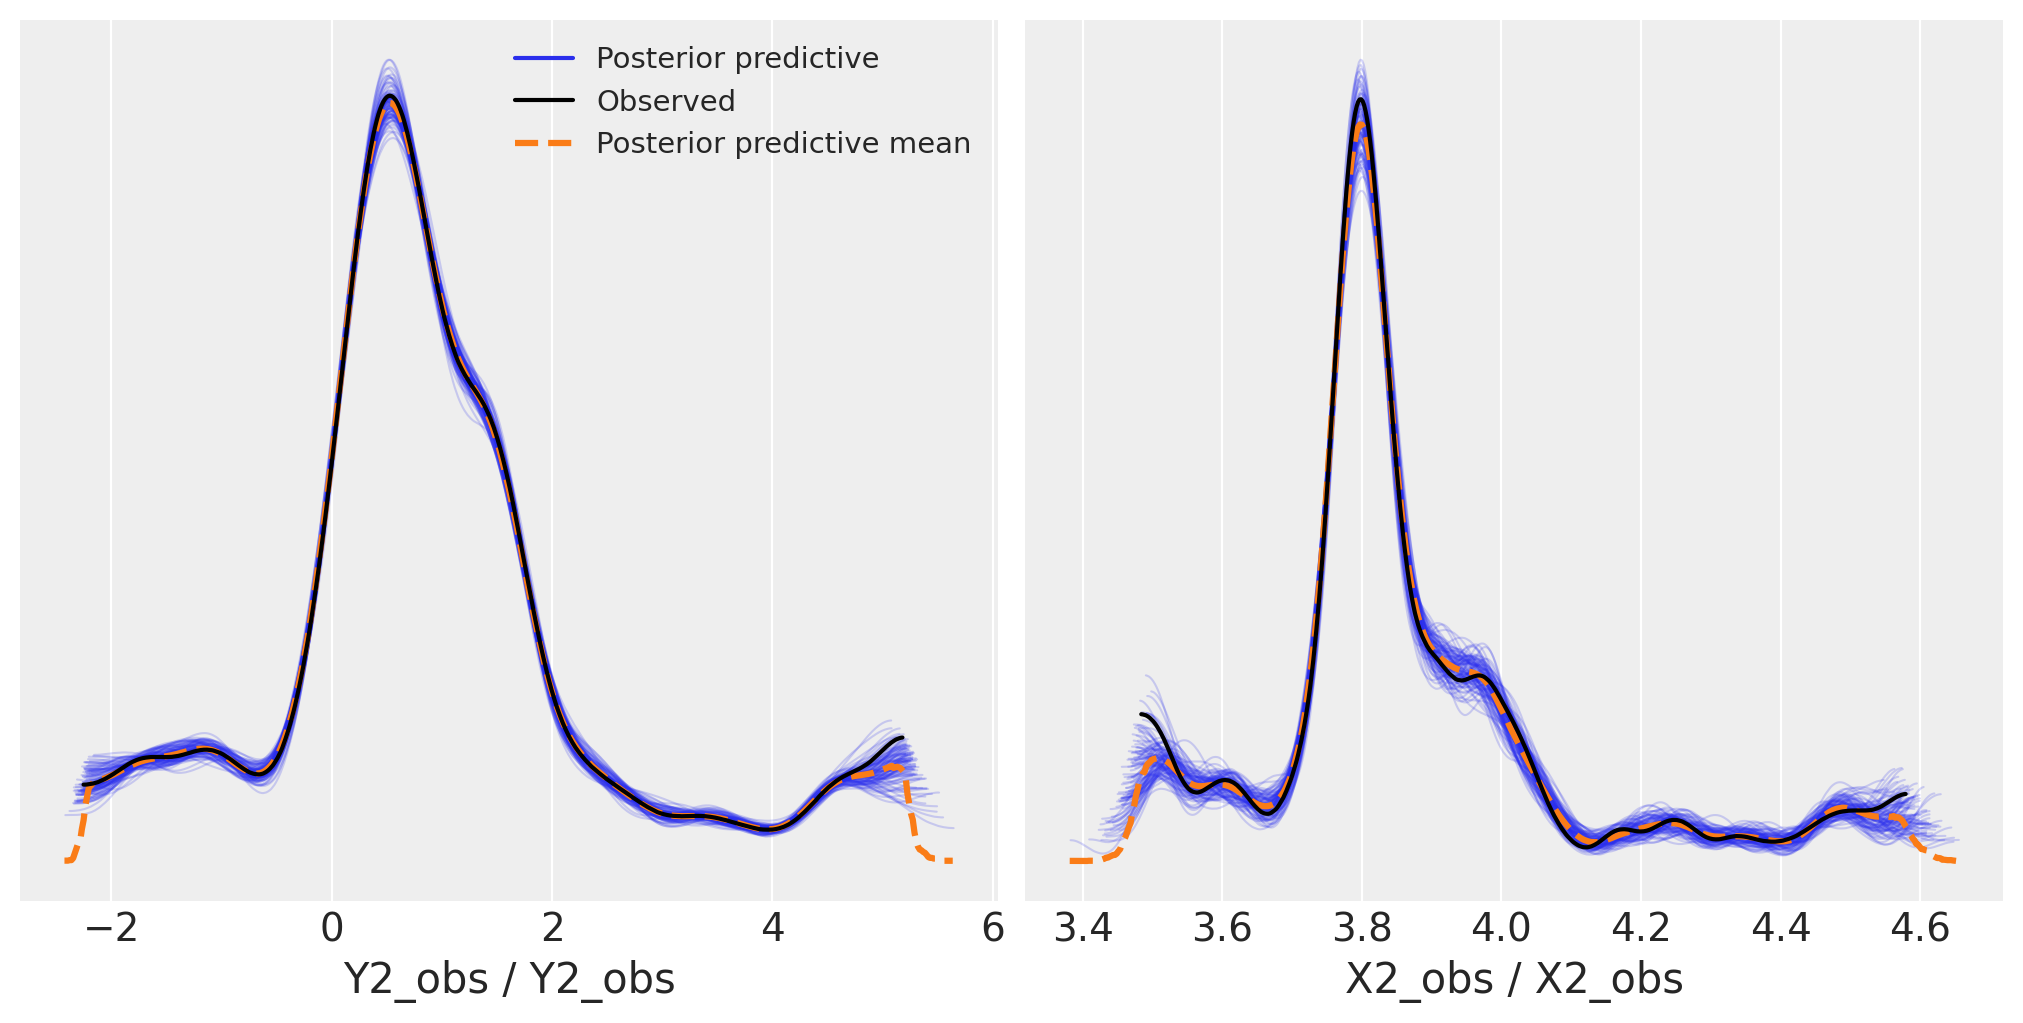

In [46]:
az.plot_ppc(trace2, num_pp_samples=100, figsize=(10,5))

In [47]:
az.summary(trace2.posterior_predictive)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Y2_obs[0]   -1.843  0.066  -1.968   -1.720      0.001    0.001    5241.0   
Y2_obs[1]   -2.258  0.053  -2.357   -2.158      0.001    0.001    4968.0   
Y2_obs[2]   -2.194  0.029  -2.247   -2.138      0.000    0.000    4467.0   
Y2_obs[3]   -1.106  0.075  -1.242   -0.961      0.001    0.001    4782.0   
Y2_obs[4]   -1.921  0.114  -2.149   -1.723      0.002    0.001    4958.0   
...            ...    ...     ...      ...        ...      ...       ...   
X2_obs[207]  4.574  0.014   4.547    4.599      0.000    0.000    4800.0   
X2_obs[208]  4.530  0.036   4.464    4.598      0.001    0.000    4843.0   
X2_obs[209]  4.538  0.035   4.471    4.603      0.001    0.000    4153.0   
X2_obs[210]  4.558  0.044   4.472    4.635      0.001    0.000    4713.0   
X2_obs[211]  4.579  0.029   4.523    4.633      0.000    0.000    5014.0   

             ess_tail  r_hat  
Y2_obs[0]      3941.0    1.0  
Y2_obs[1]      3933.0    1.0  
Y2_obs[2]      3291.0    1.0  
Y2_obs[3]      3859.0    1.0  
Y2_obs[4]      3685.0    1.0  
...               ...    ...  
X2_obs[207]    3614.0    1.0  
X2_obs[208]    3644.0    1.0  
X2_obs[209]    3277.0    1.0  
X2_obs[210]    3873.0    1.0  
X2_obs[211]    3803.0    1.0  

[424 rows x 9 columns]

## All together now

In [58]:
az.summary(trace.posterior['beta'])

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -23.614  0.35 -24.292  -22.972      0.010    0.007    1362.0   
beta[1]   6.338  0.09   6.153    6.494      0.002    0.002    1370.0   

         ess_tail  r_hat  
beta[0]    1470.0    1.0  
beta[1]    1502.0    1.0

In [59]:
az.summary(trace2.posterior['beta2'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta2[0] -23.248  3.234 -29.400  -17.398      0.059    0.042    3019.0   
beta2[1]   6.243  0.835   4.718    7.809      0.015    0.011    2988.0   

          ess_tail  r_hat  
beta2[0]    2809.0    1.0  
beta2[1]    2685.0    1.0

In [60]:
y1 = -23.614 + 6.38*xx
y2 = -23.248 + 6.243*xx

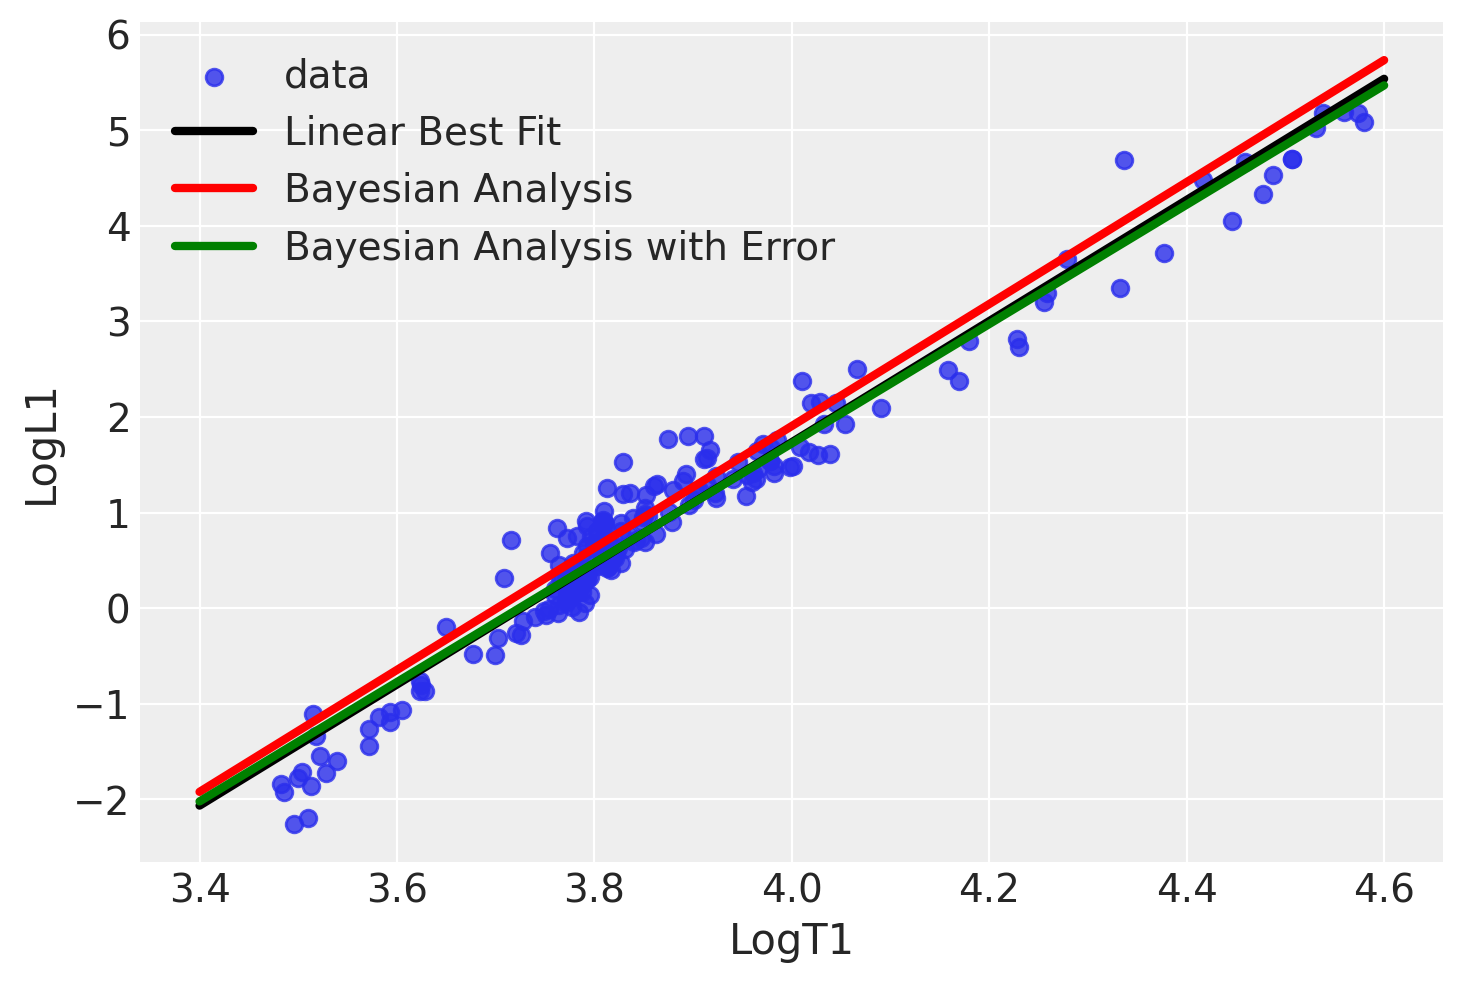

In [61]:
plt.scatter(x, y, alpha = 0.8, label='data')
plt.plot(xx, yy, 'k-', linewidth=3, label='Linear Best Fit')
plt.plot(xx, y1, 'r-', linewidth=3, label='Bayesian Analysis')
plt.plot(xx, y2, 'g-', linewidth=3, label='Bayesian Analysis with Error')
plt.xlabel(r'LogT1')
plt.ylabel(r'LogL1')
plt.legend()
plt.show()